### RANKBREEZE TAKE HOME ASSIGNMENT

#### Questions: 
Q1. Recommend the best & most likely competitors for this Airbnb property.

Q2. Recommend an optimal nightly price for the next 90 days for this property.

Q3. This property is a high-converting property & in the top 1% of properties in the city. What are some features that might make this property perform in the top 1%?


##### Data Acquisition

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns

from math import radians, sin, cos, sqrt, atan2 # to compute distance based on lat-long
from datetime import datetime
import json

from scipy.spatial.distance import cosine
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import ast



import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Reading data from csv file
df=pd.read_csv("Nashville Properties - V2.csv")
print("Shape of data:",df.shape)
data=df.copy()

Shape of data: (7733, 64)


In [3]:
# Taking a look at a sample of data
df.head()

id                          listing_url  \
0    6422    https://www.airbnb.com/rooms/6422   
1   39870   https://www.airbnb.com/rooms/39870   
2   59576   https://www.airbnb.com/rooms/59576   
3   72906   https://www.airbnb.com/rooms/72906   
4  258817  https://www.airbnb.com/rooms/258817   

                                                name  \
0                                    Nashville Charm   
1                              Close to Vanderbilt 2   
2   Large Master Suite near Lake *ladies only NS plz   
3  Vandy/Belmont/10 mins to Broadway - Sunny 800 ...   
4             ButterflyRoom-queen room, private bath   

                                         description  \
0  30 day or more rental during COVID. Show COVID...   
1  Since I am older, I need for guests to be vacc...   
2  non-smokers only please<br /><br />furnished r...   
3  Entire top floor. Private. 800 sq ft of bright...   
4  Morningstar House! Extended stay - 3+ months- ...   

                               neighborhood_overview  \
0  Historic East Nashville is home to many new an...   
1  The house is in a safe, quiet,  "college" neig...   
2  We live on a cul-de-sac in a small community o...   
3  Historic Belmont-Hillsboro neighborhood. Walk-...   
4  I'm  very near the Percy Priest Lake, natural ...   

                                         picture_url  host_id  \
0  https://a0.muscache.com/pictures/pro_photo_too...    12172   
1  https://a0.muscache.com/pictures/43420407-69b6...   171184   
2  https://a0.muscache.com/pictures/b15c851c-318e...   812128   
3  https://a0.muscache.com/pictures/58602855/3788...   176117   
4  https://a0.muscache.com/pictures/eef19bc4-2743...    22296   

                                   host_url          host_name  host_since  \
0   https://www.airbnb.com/users/show/12172            Michele  2009-04-03   
1  https://www.airbnb.com/users/show/171184             Evelyn  2010-07-18   
2  https://www.airbnb.com/users/show/812128  Patricia And John  2011-07-12   
3  https://www.airbnb.com/users/show/176117            Richard  2010-07-21   
4   https://www.airbnb.com/users/show/22296              Diana  2009-06-19   

   host_location                                         host_about  \
0  Nashville, TN  My husband and I are parents of 5 grown childr...   
1  Nashville, TN  I am a newly retired elementary school teacher...   
2            NaN  Retired Military/ Realtor/Airline.  Please cli...   
3  Nashville, TN  I was born in England and came to the US as a ...   
4  Nashville, TN  For 35 years I was serving the world as a comm...   

  host_response_time host_response_rate host_acceptance_rate  \
0                NaN                NaN                  NaN   
1     within an hour               100%                  84%   
2     within an hour               100%                  98%   
3     within an hour               100%                 100%   
4     within an hour               100%                  68%   

  host_is_superhost                                   host_picture_url  \
0                 f  https://a0.muscache.com/im/users/12172/profile...   
1                 t  https://a0.muscache.com/im/users/171184/profil...   
2                 f  https://a0.muscache.com/im/users/812128/profil...   
3                 t  https://a0.muscache.com/im/users/176117/profil...   
4                 t  https://a0.muscache.com/im/pictures/user/272f5...   

    host_neighbourhood  host_listings_count  host_total_listings_count  \
0                  NaN                  1.0                        1.0   
1                  NaN                  2.0                        2.0   
2  South Miami Heights                 19.0                       26.0   
3                  NaN                  1.0                        1.0   
4                  NaN                 21.0                       24.0   

   host_verifications host_has_profile_pic host_identity_verified  \
0           ['phone']                    t                      

##### Data Cleaning & Pre-processing

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7733 entries, 0 to 7732
Data columns (total 64 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            7733 non-null   int64  
 1   listing_url                                   7733 non-null   object 
 2   name                                          7733 non-null   object 
 3   description                                   7691 non-null   object 
 4   neighborhood_overview                         5502 non-null   object 
 5   picture_url                                   7733 non-null   object 
 6   host_id                                       7733 non-null   int64  
 7   host_url                                      7733 non-null   object 
 8   host_name                                     7653 non-null   object 
 9   host_since                                    7653 non-null   o

In [5]:
# checking for null values
df.isnull().sum()

id                                                 0
listing_url                                        0
name                                               0
description                                       42
neighborhood_overview                           2231
picture_url                                        0
host_id                                            0
host_url                                           0
host_name                                         80
host_since                                        80
host_location                                   1177
host_about                                      2350
host_response_time                               844
host_response_rate                               844
host_acceptance_rate                             607
host_is_superhost                                  1
host_picture_url                                  80
host_neighbourhood                              2412
host_listings_count                           

In [6]:
# Retrieving listing details for property of interest
print("\n\t\t\t Details of Amy's Listing (property of interest) \n\n")
amy_listing=df[df["id"]==53274690]
for i in amy_listing.columns:
    print(f"{i} - {amy_listing[i].values}\n")


			 Details of Amy's Listing (property of interest) 


id - [53274690]

listing_url - ['https://www.airbnb.com/rooms/53274690']

name - ['Stunning 6 Beds Condo Near Downtown - Parking+Pool']

description - ['STUNNING 2 Bedroom, 1 Bath & 6 BEDS condo with a huge glass garage door. This condo has been used for numerous photo shoots. Located in the 1865 building, which is a  super dynamic & unique building - truly one of a kind. Pool,  Bar Area with a Grill, Gym and Outdoor Seating! Great kitchen for all your cooking needs. FREE gated Parking plus washer/dryer in the unit. Only a short 2 mile Uber away from downtown & 1 mile from Vanderbilt. Walk to 2 blocks to Starbucks. An upscale experience!<br /><br /><b>The space</b><br />2 Bedrooms, 1 Bath, 6 Beds<br /><br />Part of the brand-new community at The 1865, this 2BR luxury condo boasts one-of-a-kind details like a huge glass garage door. Host a cookout by the heated plunge pool, then watch the stars come out on the observation deck!<br 

In [7]:
print("Types of Listings by room type:\n\n", df.room_type.value_counts())

Types of Listings by room type:

 Entire home/apt    6858
Private room        839
Hotel room           25
Shared room          11
Name: room_type, dtype: int64


In [8]:
# Function to pre-process data
def data_preprocessing(df1):
    df=df1.copy()
    # Drop columns with all null values
    df = df.dropna(axis=1, how='all')

    # Filtering properties in Nashville city, as we are looking for competitors of a property in Nashville.
    df=df[df["host_location"]=='Nashville, TN']
    df=df[df["minimum_nights"]<5]
    relevant_columns=["id","description","host_since",
                      "host_is_superhost","latitude","longitude",
                      "room_type","accommodates","bathrooms_text","bedrooms",
                      "beds","amenities","price","number_of_reviews","number_of_reviews_ltm","number_of_reviews_l30d",
                      "review_scores_rating","review_scores_accuracy","review_scores_cleanliness",
                      "review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"]
    df=df[relevant_columns]

    #replacing date column with number of months old column
    df["number_of_months_old"] = round(pd.to_timedelta(pd.Timestamp.now() - pd.to_datetime(df['host_since'])).dt.days/30)

    # Map t and f values to 1 and 0 respectively
    df['host_is_superhost'] = df['host_is_superhost'].replace({'t': 1, 'f': 0})

    # combining lat long
    df["lat_long"] = list(zip(df["latitude"], df["longitude"]))

    amy_listing_latlong = df[df['id']==53274690]["lat_long"].values[0]
    df["amy_listing_latlong"]=[amy_listing_latlong] * len(df)

    # Apply the distance calculation function to the columns and create a new column 'distance'
    df['distance_kms'] = df.apply(lambda x: calculate_distance(x['lat_long'][0], x['lat_long'][1], x['amy_listing_latlong'][0], x['amy_listing_latlong'][1]), axis=1)

    #creating dummies for categorical columns
    df = pd.get_dummies(df, columns=["room_type"], drop_first=True)
    
    # clean and process the # bathrooms and price variables
    df['bathrooms_text'] = df['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)
    df['price'] = df['price'].str.replace('$', '', regex=False).str.replace(',', '').astype(float)
    
    # dropping unnecessary columns
    df = df.drop(['lat_long','amy_listing_latlong','host_since','latitude','longitude'], axis=1)
    
    # function call to process amenities column into different features
    df,amenities_cols = process_amenities(df)

    return df,amenities_cols

# Function to calculate distance between 2 latlong columns using Haversine formula
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    earth_radius = 6371 # in kms
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2 #     
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = earth_radius * c # unit of distance in kms.
    return distance


def process_amenities(df):
    amenities_list = df['amenities'].tolist()
    exhaustive_list=[]
    # getting an exhaustive list of amenities
    for i in amenities_list:
        for j in json.loads(i):
            if j not in exhaustive_list:
                exhaustive_list.append(j)
    
    df['amenities'] = df['amenities'].apply(lambda x: json.loads(x))
    df['amenities']=df['amenities'].apply(lambda x: map_amenities(x))
    exhaustive_list=map_amenities(exhaustive_list)
    
    temp = pd.DataFrame(columns=exhaustive_list)

    # Iterate over each amenity
    for amenity in exhaustive_list:
        # Create a new column for the amenity
        temp[amenity] = df['amenities'].apply(lambda x: 1 if amenity in x else 0)
    temp["total_amenities"]=temp.sum(axis=1)
    df=pd.concat([df]+[temp],axis=1)
    df = df.drop('amenities', axis=1)
    df["Air conditioning"] = df.apply(lambda row: max(row["Air conditioning"], row["Window AC unit"]), axis=1)
    df["coffee"] = df.apply(lambda row: max(row["coffee"], row["Nespresso machine"]), axis=1)
    df["gym"] = df.apply(lambda row: max(row["gym"], row["Fitness center"]), axis=1)
    df["Toiletries"] = df.apply(lambda row: max(row["Toiletries"], row["shampoo"]), axis=1)
    df["Toiletries"] = df.apply(lambda row: max(row["Toiletries"], row["conditioner"]), axis=1)
    cols_to_remove=["Window AC unit","Nespresso machine","Fitness center","shampoo","conditioner"]

    df=df.drop(cols_to_remove,axis=1)
    amenities_cols = temp.columns.tolist()
    amenities_cols = [i for i in amenities_cols if i not in cols_to_remove]

    return df,amenities_cols
                
                

def map_amenities(listing_amenities):
    amenities_=['TV', 'soap','wifi', 'Tub', 'Oven', 'Sound', 'stove', 'pool', 'shampoo', 'conditioner','parking',
           'washer', 'dryer','refrigerator','dishwasher','console','Clothing storage', 'gym','EV charger',
           'Children’s books and toys','bed','Crib','chair','Free carport','garage','Heating','coffee',
            'fireplace','Air conditioning','kitchen', 'garden','alarm']
    updated_amenities=listing_amenities
    for t in amenities_:
        updated_amenities = [t if t.lower() in i.lower() else i for i in updated_amenities]
    updated_amenities=list(set(updated_amenities))
    return updated_amenities



In [9]:
df_cleaned,amenities= data_preprocessing(df)
print("Shape of data:",df_cleaned.shape)
df_cleaned.head(3)


Shape of data: (4422, 143)


id                                        description  \
1   39870  Since I am older, I need for guests to be vacc...   
3   72906  Entire top floor. Private. 800 sq ft of bright...   
7  329997  Gorgeous cottage with private entry, courtyard...   

   host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
1                1.0             2             1.0       1.0   1.0   72.0   
3                1.0             2             1.0       2.0   2.0  105.0   
7                1.0             2             1.0       1.0   1.0  111.0   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
1                328                     64                       5   
3                658                     56                       5   
7               1197                    110                       9   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
1                  4.94                    4.96                       4.95   
3                  4.91                    4.90                       4.81   
7                  4.89                    4.92                       4.93   

   review_scores_checkin  review_scores_communication  review_scores_location  \
1                   4.98                         4.97                    4.95   
3                   4.98                         4.99                    4.96   
7                   4.94                         4.94                    4.58   

   review_scores_value  number_of_months_old  distance_kms  \
1                 4.94                 158.0      3.842908   
3                 4.89                 157.0      3.159843   
7                 4.88                 139.0      1.917242   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  gym  \
1                     0                       1                      0    0   
3                     0                       0                      0    0   
7                     0                       0                      0    0   

   Concierge  Ski-in/Ski-out  Bathroom essentials  Bidet  Cleaning products  \
1          0               0                    0      0                  0   
3          0               0                    0      0                  0   
7          0               0                    0      0                  0   

   Sound  EV charger  Smoking allowed  Self check-in  alarm  Piano  \
1      0           0                0              0      1      0   
3      0           0                0              0      1      0   
7      0           0                0              0      1      0   

   Mini fridge  Air conditioning  First aid kit  Essentials  Heating  \
1            0                 1              0           1        1   
3            0                 1              1           1        1   
7            0                 0              1           1        1   

   Children’s books and toys  Barbecue utensils  Host greets you  \
1                          0                  0                0   
3                          0                  0                0   
7                          0                  0                0   

   Pets allowed  TV  Elevator  parking  BBQ grill  Backyard  Lake access  \
1             0   0         0        1          0         0            0   
3             0   1         0        1          0         1            0   
7             0   1         0        1          0         0            0   

   console  Long term stays allowed  Ping pong table  Luggage dropoff allowed  \
1        0                        1                0                        1   
3        0                        0                0                        1   
7        0                        1                0                        1   

   Free carport  Freezer  Private entrance  Microwave  Boat slip  \
1             0        0                 0          1          0   
3             0        0  

In [10]:
# pip install -U sentence-transformers

In [11]:
# # Bert performs better than word2vec for sentence embeddings, 
# # but we go ahead with word2vec embeddings for lack of compute power

# from sentence_transformers import SentenceTransformer 

# def sentence_bert(description):
#     model = SentenceTransformer('paraphrase-MiniLM-L6-v2') 
#     embedding = model.encode(description)
#     return bert_feature_vector

In [12]:
def preprocess_text(text):
    
    stop_words = set(stopwords.words('english'))
    # Tokenize text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    filtered_tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
    # Join tokens back into a single string
    preprocessed_text = ' '.join(filtered_tokens)
    return preprocessed_text

def process_description(df_cleaned,amy_listing):
    
    # nltk.download('stopwords')
    # nltk.download('punkt')
    df=df_cleaned.copy()
    descriptions_list = df['description'].astype(str).tolist()
    word2vec_model=build_w2v(descriptions_list)
    
    reference_description = amy_listing['description'].astype(str).tolist()[0]
    reference_vector = get_word2vec_features(reference_description,word2vec_model)
    # reference_vector = sentence_bert(reference_description)


    # Compute the distance for each description
    distances = []
    for description in df['description'].astype(str):
        feature_vector = get_word2vec_features(description,word2vec_model)
        # feature_vector = sentence_bert(description)

        if np.count_nonzero(feature_vector) == 0 or np.count_nonzero(reference_vector) == 0:
            distance = np.nan  # Assign NaN for invalid distances
        else:
            # Compute the cosine distance between the feature vector and reference vector
            distance = cosine(feature_vector, reference_vector)

        # Append the distance to the list
        distances.append(distance)

    # Add the distances as a new column in the DataFrame
    df['word2vec_distance'] = distances
    df = df.drop(['description'], axis=1)
    df = df.dropna()
    print("Cross-checking word2vec distance of Amy's listing; expected to be 0 : \n",df[df['id']==53274690]['word2vec_distance'].values)
    
    return df

def build_w2v(descriptions_list):
    sentences = [word_tokenize(preprocess_text(description)) for description in descriptions_list]
    word2vec_model = Word2Vec(sentences, vector_size=100, min_count=1)
    return word2vec_model

def get_word2vec_features(description,word2vec_model):
    # Tokenize the descriptions and create sentences
    feature_vector = np.zeros(word2vec_model.vector_size)
    for word in word_tokenize(preprocess_text(description)):
        if word in word2vec_model.wv:
            feature_vector += word2vec_model.wv[word]
    return feature_vector



In [13]:
df_preprocessed=process_description(df_cleaned,amy_listing)
df_preprocessed.to_csv("Nashville_property_listings_data_preprocessed.csv")
id=df_preprocessed[["id"]]
df_preprocessed = df_preprocessed.drop(['id'], axis=1)


Cross-checking word2vec distance of Amy's listing; expected to be 0 : 
 [0.]


In [14]:
basic_requirement=['accommodates','bathrooms_text','bedrooms','beds','room_type_Hotel room',
                   'room_type_Private room','room_type_Shared room']
location = ['distance_kms','review_scores_location']
value = ['price','review_scores_value']

experience = ['host_is_superhost','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
              'review_scores_checkin','review_scores_communication',
              'number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d']
    
others = list(set(df_preprocessed.columns.tolist())-set(basic_requirement)-set(location)
                  -set(value)-set(experience)-set(amenities))

print("Shape of data:",df_preprocessed.shape)
df_preprocessed.head(3)

Shape of data: (3995, 142)


host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
1                1.0             2             1.0       1.0   1.0   72.0   
3                1.0             2             1.0       2.0   2.0  105.0   
7                1.0             2             1.0       1.0   1.0  111.0   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
1                328                     64                       5   
3                658                     56                       5   
7               1197                    110                       9   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
1                  4.94                    4.96                       4.95   
3                  4.91                    4.90                       4.81   
7                  4.89                    4.92                       4.93   

   review_scores_checkin  review_scores_communication  review_scores_location  \
1                   4.98                         4.97                    4.95   
3                   4.98                         4.99                    4.96   
7                   4.94                         4.94                    4.58   

   review_scores_value  number_of_months_old  distance_kms  \
1                 4.94                 158.0      3.842908   
3                 4.89                 157.0      3.159843   
7                 4.88                 139.0      1.917242   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  gym  \
1                     0                       1                      0    0   
3                     0                       0                      0    0   
7                     0                       0                      0    0   

   Concierge  Ski-in/Ski-out  Bathroom essentials  Bidet  Cleaning products  \
1          0               0                    0      0                  0   
3          0               0                    0      0                  0   
7          0               0                    0      0                  0   

   Sound  EV charger  Smoking allowed  Self check-in  alarm  Piano  \
1      0           0                0              0      1      0   
3      0           0                0              0      1      0   
7      0           0                0              0      1      0   

   Mini fridge  Air conditioning  First aid kit  Essentials  Heating  \
1            0                 1              0           1        1   
3            0                 1              1           1        1   
7            0                 0              1           1        1   

   Children’s books and toys  Barbecue utensils  Host greets you  \
1                          0                  0                0   
3                          0                  0                0   
7                          0                  0                0   

   Pets allowed  TV  Elevator  parking  BBQ grill  Backyard  Lake access  \
1             0   0         0        1          0         0            0   
3             0   1         0        1          0         1            0   
7             0   1         0        1          0         0            0   

   console  Long term stays allowed  Ping pong table  Luggage dropoff allowed  \
1        0                        1                0                        1   
3        0                        0                0                        1   
7        0                        1                0                        1   

   Free carport  Freezer  Private entrance  Microwave  Boat slip  \
1             0        0                 0          1          0   
3             0        0                 0          1          0   
7             0        0                 1          1          0   

   Patio or balcony  Beach essentials  chair  Dedicated workspace  \
1                 0                 0      0                    0   
3   

##### Exploratory data analyis

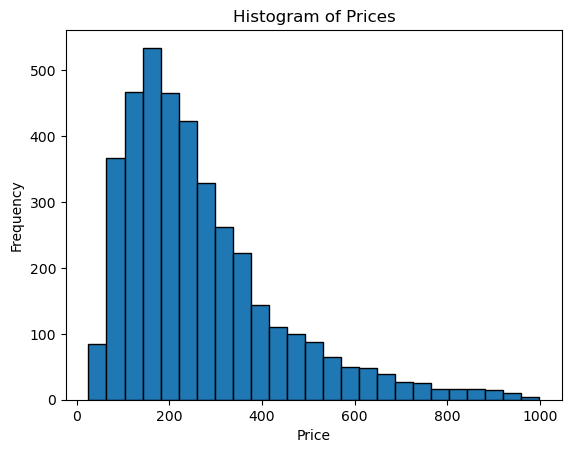

In [15]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is called 'df' and the price column is named 'price'
price_values = df_preprocessed[df_preprocessed['price']<1000]['price']

# Plotting the histogram
plt.hist(price_values, bins=25, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Prices')
plt.show()


In [16]:
df_preprocessed.info(verbose=True,show_counts=True)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3995 entries, 1 to 7727
Data columns (total 142 columns):
 #    Column                           Non-Null Count  Dtype  
---   ------                           --------------  -----  
 0    host_is_superhost                3995 non-null   float64
 1    accommodates                     3995 non-null   int64  
 2    bathrooms_text                   3995 non-null   float64
 3    bedrooms                         3995 non-null   float64
 4    beds                             3995 non-null   float64
 5    price                            3995 non-null   float64
 6    number_of_reviews                3995 non-null   int64  
 7    number_of_reviews_ltm            3995 non-null   int64  
 8    number_of_reviews_l30d           3995 non-null   int64  
 9    review_scores_rating             3995 non-null   float64
 10   review_scores_accuracy           3995 non-null   float64
 11   review_scores_cleanliness        3995 non-null   float64
 12   revi

In [17]:
reference_property= df_preprocessed.loc[5196]

In [18]:
import math
   # Function to remove outliers using Tukey's fences
def remove_outliers(data, k=1.5):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    fence_low = q1 - k * iqr
    fence_high = q3 + k * iqr
    outliers = (data < fence_low) | (data > fence_high)
    return data[~outliers]

def eda_plots(df,features):

    # Setting custom layout parameters
    num_rows = math.ceil(len(features)/2)
    num_cols = 2
    fig_width = num_cols*8
    fig_height = num_rows*3.5

    # Creating subplots with custom layout
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(fig_width, fig_height), sharey=False)

 
    
    axes = axes.reshape(num_rows, num_cols)

    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]
        data = df[feature]

        # Handling binary features
        if np.array_equal(np.sort(data.unique()), [0, 1]):
            sns.countplot(x=data, ax=ax)
            ax.axhline(0, color='red', linestyle='dashed', linewidth=2)
            ax.text(reference_property[feature], ax.get_ylim()[1], f"Ref: {reference_property[feature]}", color='red', verticalalignment='top', horizontalalignment='right')
            ax.set_xticklabels(['No', 'Yes'])
            ax.set_xlabel(feature)
        else:
            data_no_outliers = remove_outliers(data)
            sns.histplot(x=data_no_outliers, kde=True, ax=ax)
            ax.axvline(reference_property[feature], color='red', linestyle='dashed', linewidth=2)
            ax.text(reference_property[feature], ax.get_ylim()[1]*1.01, f"Ref: {reference_property[feature]}", color='red', verticalalignment='top', horizontalalignment='right')
            ax.set_xlabel(feature)
            ax.set_ylabel('Frequency')

        ax.set_title(f'Distribution of {feature}')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


    # Adjusting the spacing between subplots
    plt.subplots_adjust(wspace=0.25, hspace=0.6)

    # Displaying the plot

    plt.show()


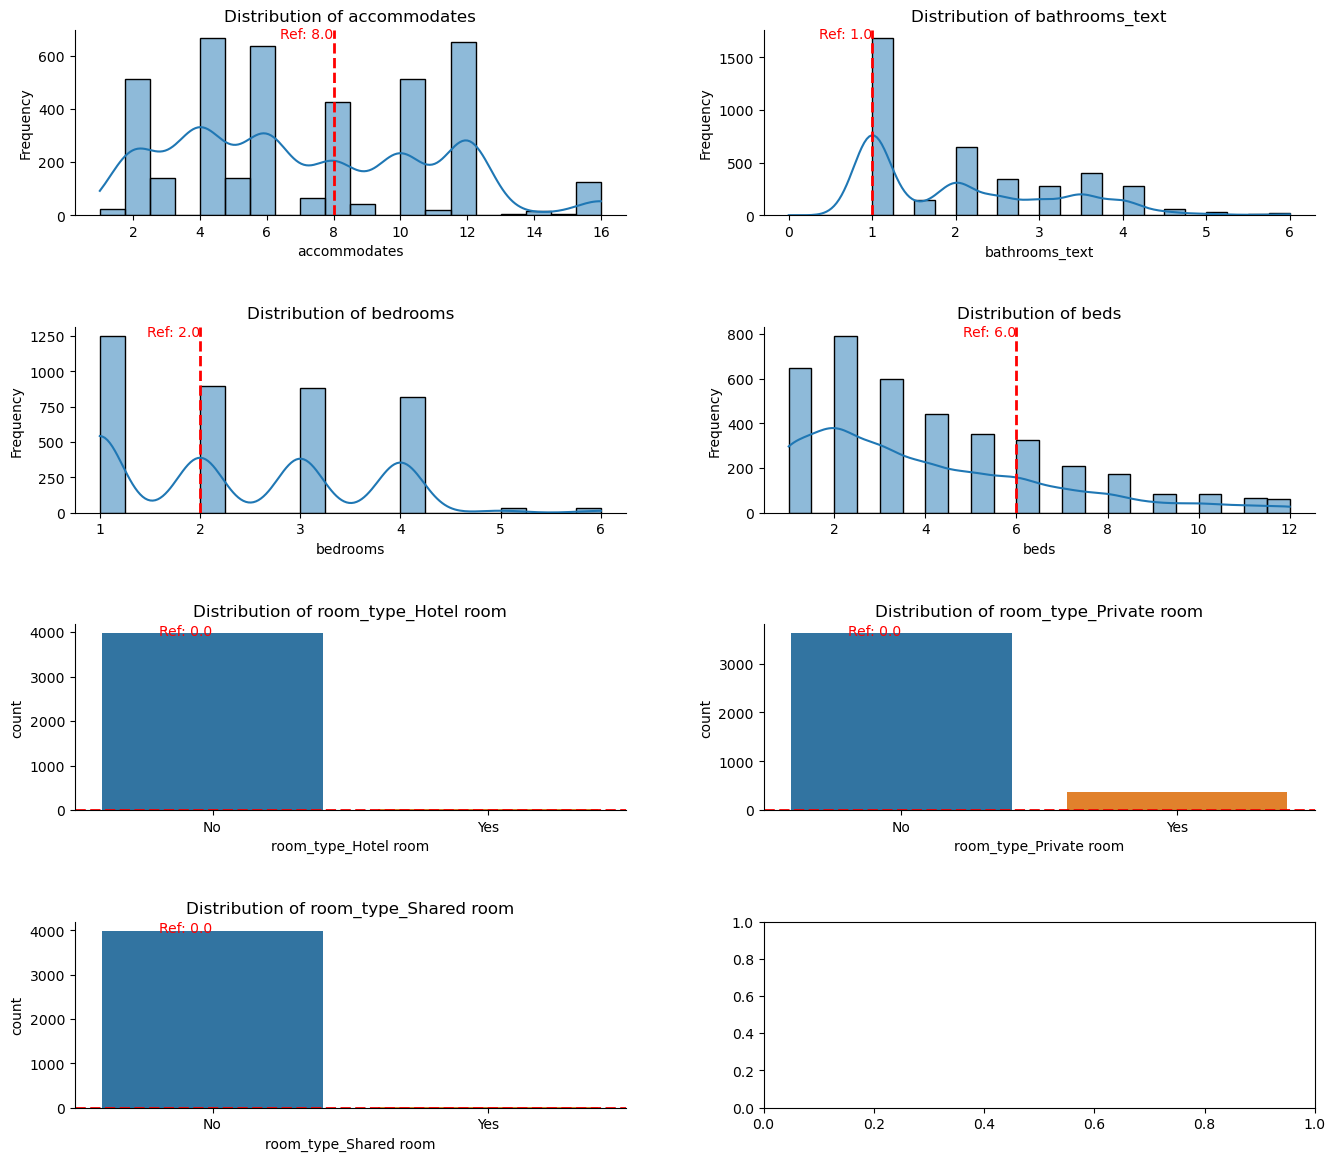

In [19]:
eda_plots(df_preprocessed,basic_requirement)

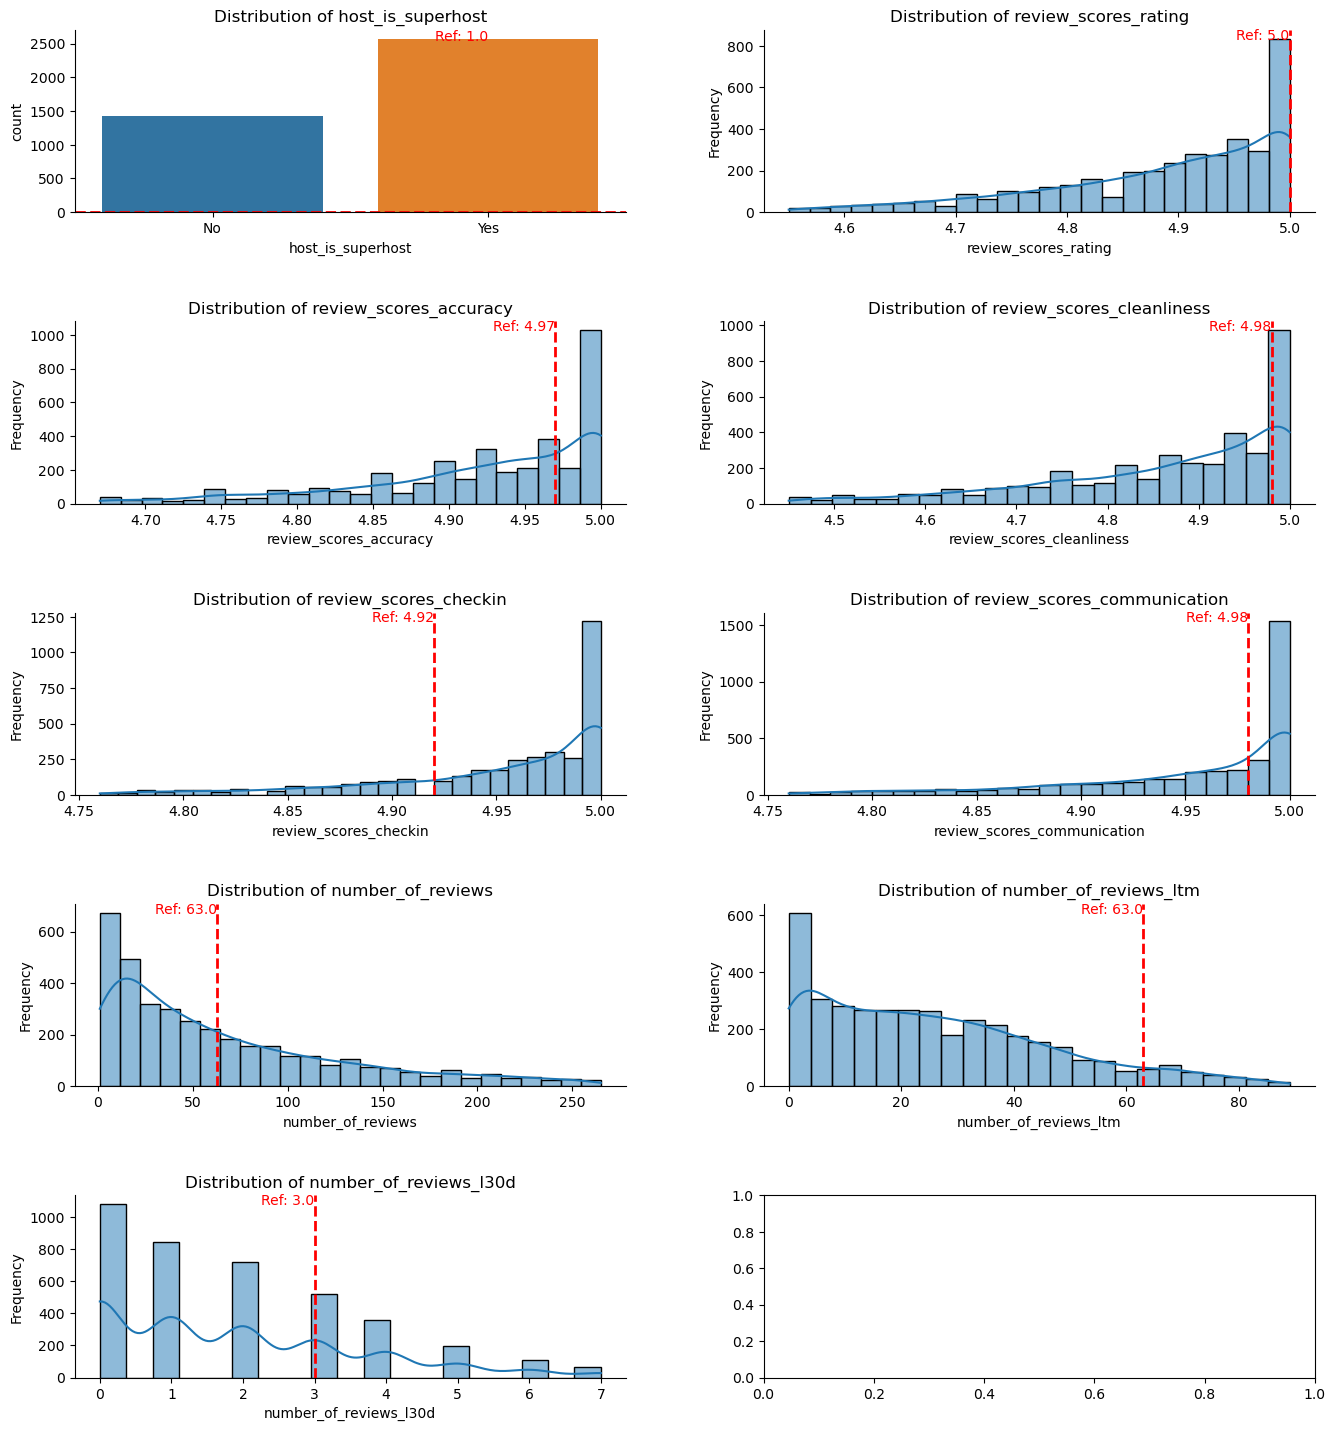

In [20]:
eda_plots(df_preprocessed,experience)


All experience ratings are top notch for Amy's properties

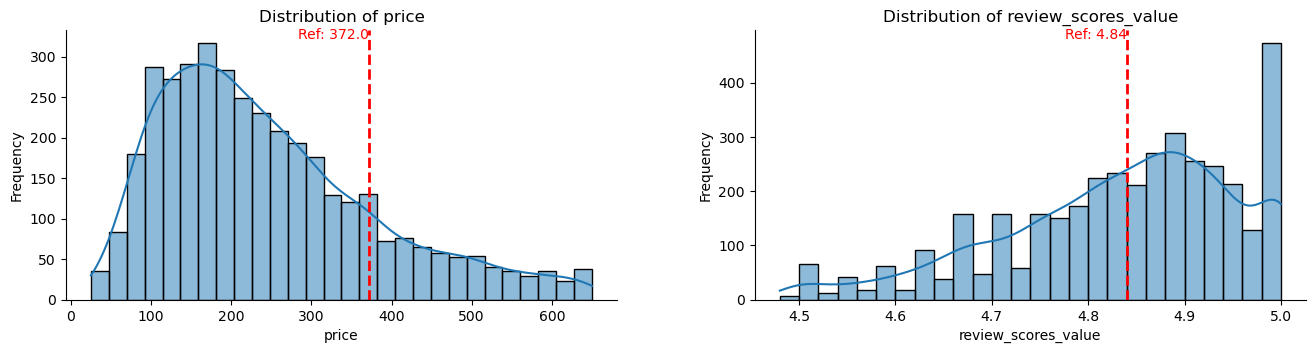

In [21]:
eda_plots(df_preprocessed,value)


- Amy's property is not economically priced, but at the same time definitely not the most pricey ones as well. But price could be due to a variety of factors - # number of bedrooms,timing of the week (weekday/weekend),location, amenities etc. 
- Perceived value for the price is also high

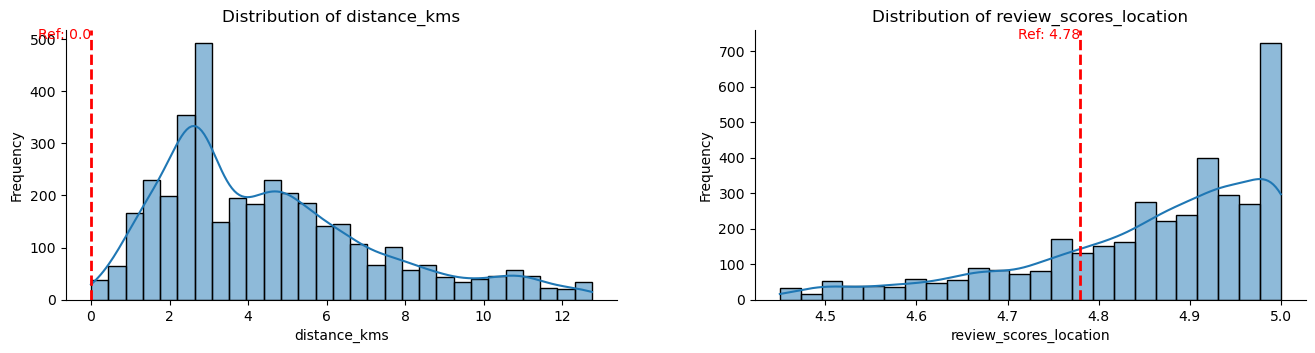

In [22]:
eda_plots(df_preprocessed,location)



The distance plotted is the distance of all properties from Amy's property. Hence reference value is 0

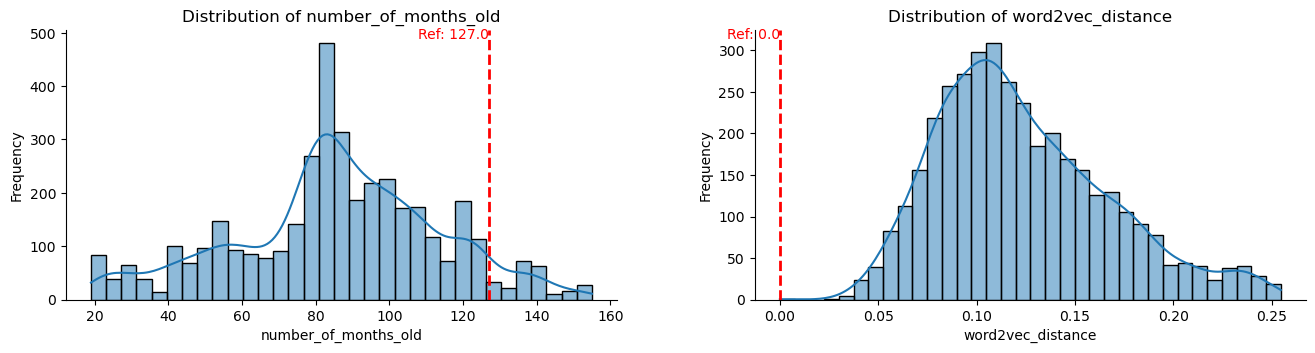

In [23]:
eda_plots(df_preprocessed,others)



- Amy's property is definitely not one of the newest properties in town. 
- Also, Word2Vec_distance here captures the Cosine distance of the property's description with respect to that of Amy's property. Hence, a ref value of 0 again.

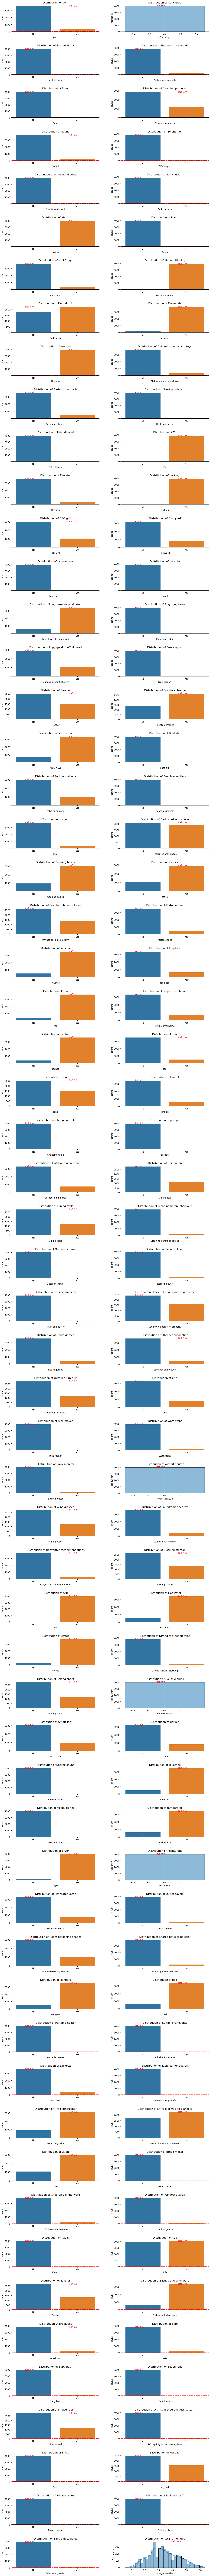

In [24]:
eda_plots(df_preprocessed,amenities)

##### Modeling

#### Q1. Recommend the best & most likely competitors for this Airbnb property.

In [25]:

df_preprocessed.head(3)


host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
1                1.0             2             1.0       1.0   1.0   72.0   
3                1.0             2             1.0       2.0   2.0  105.0   
7                1.0             2             1.0       1.0   1.0  111.0   

   number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
1                328                     64                       5   
3                658                     56                       5   
7               1197                    110                       9   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
1                  4.94                    4.96                       4.95   
3                  4.91                    4.90                       4.81   
7                  4.89                    4.92                       4.93   

   review_scores_checkin  review_scores_communication  review_scores_location  \
1                   4.98                         4.97                    4.95   
3                   4.98                         4.99                    4.96   
7                   4.94                         4.94                    4.58   

   review_scores_value  number_of_months_old  distance_kms  \
1                 4.94                 158.0      3.842908   
3                 4.89                 157.0      3.159843   
7                 4.88                 139.0      1.917242   

   room_type_Hotel room  room_type_Private room  room_type_Shared room  gym  \
1                     0                       1                      0    0   
3                     0                       0                      0    0   
7                     0                       0                      0    0   

   Concierge  Ski-in/Ski-out  Bathroom essentials  Bidet  Cleaning products  \
1          0               0                    0      0                  0   
3          0               0                    0      0                  0   
7          0               0                    0      0                  0   

   Sound  EV charger  Smoking allowed  Self check-in  alarm  Piano  \
1      0           0                0              0      1      0   
3      0           0                0              0      1      0   
7      0           0                0              0      1      0   

   Mini fridge  Air conditioning  First aid kit  Essentials  Heating  \
1            0                 1              0           1        1   
3            0                 1              1           1        1   
7            0                 0              1           1        1   

   Children’s books and toys  Barbecue utensils  Host greets you  \
1                          0                  0                0   
3                          0                  0                0   
7                          0                  0                0   

   Pets allowed  TV  Elevator  parking  BBQ grill  Backyard  Lake access  \
1             0   0         0        1          0         0            0   
3             0   1         0        1          0         1            0   
7             0   1         0        1          0         0            0   

   console  Long term stays allowed  Ping pong table  Luggage dropoff allowed  \
1        0                        1                0                        1   
3        0                        0                0                        1   
7        0                        1                0                        1   

   Free carport  Freezer  Private entrance  Microwave  Boat slip  \
1             0        0                 0          1          0   
3             0        0                 0          1          0   
7             0        0                 1          1          0   

   Patio or balcony  Beach essentials  chair  Dedicated workspace  \
1                 0                 0      0                    0   
3   

In [26]:
# Scaling is required for Euclidean distance metric and not necessary for Cosine distance ( 1- cosine similarity)

# from sklearn.preprocessing import MinMaxScaler
# def scale_df(df):
#     scaler = MinMaxScaler()
#     df_normalized = pd.DataFrame(scaler.fit_transform(df.values), index=df.index, columns=df.columns)
#     return df_normalized
# df=scale_df(df)


In [27]:
# Clustering for property segmentation.

def get_segments(df_preprocessed,target_index):

    data = df_preprocessed.copy()
    target_property = data.loc[target_index].values.reshape(1, -1)

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    target_property_scaled = scaler.transform(target_property)


    pca = PCA(n_components=30)
    data_pca = pca.fit_transform(data_scaled)

    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(data_scaled)
    target_cluster_kmeans = kmeans.predict(target_property_scaled)[0]
    kmeans_labels = kmeans.labels_
    print("Cluster in which Amy's listing is - ", target_cluster_kmeans)
    df_amy_cluster = data[kmeans_labels == target_cluster_kmeans] 


    plt.figure(figsize=(10, 4))
    for label in np.unique(kmeans_labels):
        plt.scatter(data_pca[kmeans_labels == label, 0], data_pca[kmeans_labels == label, 1], label=f'Cluster {label}')
    plt.title("K-Means Clustering")
    plt.legend()
    plt.show()
    return df_amy_cluster,target_cluster_kmeans,kmeans_labels



Cluster in which Amy's listing is -  0


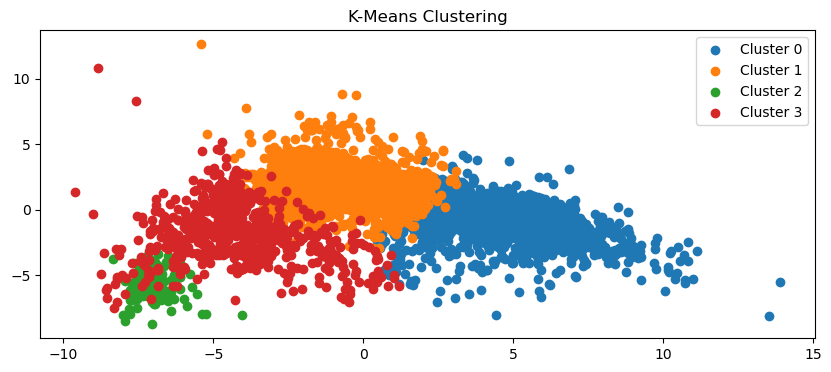

In [28]:
target_index=5196
df_amy_cluster,target_cluster_kmeans,kmeans_labels = get_segments(df_preprocessed,target_index)

In [29]:
print(df_amy_cluster.shape)
df_amy_cluster.head()

(1205, 142)


host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
10                1.0             2             1.0       1.0   1.0  106.0   
11                1.0             4             2.5       2.0   2.0  302.0   
15                0.0             3             1.0       1.0   2.0  142.0   
20                1.0             6             1.0       1.0   4.0  242.0   
23                0.0             4             1.0       2.0   5.0  108.0   

    number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
10                948                     74                       4   
11                472                     37                       3   
15                426                     31                       4   
20                328                     55                       5   
23                225                     13                       2   

    review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
10                  4.95                    4.97                       4.98   
11                  4.88                    4.92                       4.94   
15                  4.87                    4.90                       4.89   
20                  4.72                    4.75                       4.78   
23                  4.94                    4.95                       4.93   

    review_scores_checkin  review_scores_communication  \
10                   4.97                         4.96   
11                   4.97                         4.95   
15                   4.96                         4.92   
20                   4.90                         4.93   
23                   4.98                         5.00   

    review_scores_location  review_scores_value  number_of_months_old  \
10                    4.80                 4.94                 139.0   
11                    4.41                 4.86                 139.0   
15                    4.88                 4.88                 132.0   
20                    4.68                 4.66                 127.0   
23                    4.92                 4.94                 125.0   

    distance_kms  room_type_Hotel room  room_type_Private room  \
10      1.873417                     0                       0   
11      1.917242                     0                       0   
15      2.151370                     0                       1   
20      2.791429                     0                       0   
23     10.828765                     0                       0   

    room_type_Shared room  gym  Concierge  Ski-in/Ski-out  \
10                      0    0          0               0   
11                      0    0          0               0   
15                      0    0          0               0   
20                      0    1          0               0   
23                      0    0          0               0   

    Bathroom essentials  Bidet  Cleaning products  Sound  EV charger  \
10                    0      0                  1      0           0   
11                    0      0                  1      0           0   
15                    0      0                  0      0           0   
20                    0      0                  1      0           0   
23                    0      0                  1      0           0   

    Smoking allowed  Self check-in  alarm  Piano  Mini fridge  \
10                0              0      1      0            1   
11                0              0      1      0            0   
15                0              0      1      0            1   
20                0              0      1      0            0   
23                0              0      1      0            0   

    Air conditioning  First aid kit  Essentials  Heating  \
10                 1              1           1        1   
11                 1              1           1        1   
15                 1              1           1        1   
20         

##### We can approach this in two ways : 
- a) either consider only Amy's segment and compute distance for properties within the segment to identify competitors or 
- b) compute distance scores for all filtered properties and rank them accordingly.

I have identified top competitors by both approaches

In [30]:
from scipy.spatial.distance import cosine

def calculate_distance_metric(df,amenities,experience_wt=0.35,value_wt=0.35,location_wt=0.2,basic_requirement_wt=0.05,amenities_wt=0.04,others_wt=0.01):
    row2 = df.loc[5196]
    distances = []
    for i in df.index:
        row1 = df.loc[i]
        distance = weighted_distance(row1,row2,df,amenities,experience_wt,value_wt,location_wt,basic_requirement_wt,amenities_wt,others_wt)
        distances.append(distance)
    df['competitor_distance_wrt_AMY'] = distances
    return df

def weighted_distance(row1,row2,df,amenities,experience_wt,value_wt,location_wt,basic_requirement_wt,amenities_wt,others_wt):

    
    #creating different feature categories
    basic_requirement=['accommodates','bathrooms_text','bedrooms','beds','room_type_Hotel room',
                   'room_type_Private room','room_type_Shared room']
    location = ['distance_kms','review_scores_location']
    value = ['price','review_scores_value']

    experience = ['host_is_superhost','review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
              'review_scores_checkin','review_scores_communication','number_of_reviews',
                  'number_of_reviews_ltm','number_of_reviews_l30d']
    
    others = list(set(df.columns.tolist())-set(basic_requirement)-set(location)
                  -set(value)-set(experience)-set(amenities))
   
    # Weightages based on which similarity to be computed
    experience_wt = experience_wt/len(experience)
    value_wt = value_wt/len(value)
    location_wt= location_wt/len(location)
    basic_requirement_wt = basic_requirement_wt/len(basic_requirement)
    amenities_wt = amenities_wt /len(amenities)
    others_wt = others_wt/len(others)
    
    basic_requirement_dist =cosine(row1[basic_requirement],row2[basic_requirement])*basic_requirement_wt
    location_dist =cosine(row1[location],row2[location])*location_wt
    value_dist =cosine(row1[value],row2[value])*value_wt
    experience_dist =cosine(row1[experience],row2[experience])*experience_wt
    amenities_dist =cosine(row1[amenities],row2[amenities])*amenities_wt
    others_dist =cosine(row1[others],row2[others])*others_wt
    
    total_dist = basic_requirement_dist+location_dist+value_dist+experience_dist+amenities_dist+others_dist
    
    return total_dist
    
    


In [31]:
df_model_q1a=calculate_distance_metric(df_amy_cluster,amenities)
df_model_q1b=calculate_distance_metric(df_preprocessed,amenities)

df_model_q1a.shape,df_model_q1b.shape

((1205, 143), (3995, 143))

In [32]:
df_model_q1a.head()

host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
10                1.0             2             1.0       1.0   1.0  106.0   
11                1.0             4             2.5       2.0   2.0  302.0   
15                0.0             3             1.0       1.0   2.0  142.0   
20                1.0             6             1.0       1.0   4.0  242.0   
23                0.0             4             1.0       2.0   5.0  108.0   

    number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
10                948                     74                       4   
11                472                     37                       3   
15                426                     31                       4   
20                328                     55                       5   
23                225                     13                       2   

    review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
10                  4.95                    4.97                       4.98   
11                  4.88                    4.92                       4.94   
15                  4.87                    4.90                       4.89   
20                  4.72                    4.75                       4.78   
23                  4.94                    4.95                       4.93   

    review_scores_checkin  review_scores_communication  \
10                   4.97                         4.96   
11                   4.97                         4.95   
15                   4.96                         4.92   
20                   4.90                         4.93   
23                   4.98                         5.00   

    review_scores_location  review_scores_value  number_of_months_old  \
10                    4.80                 4.94                 139.0   
11                    4.41                 4.86                 139.0   
15                    4.88                 4.88                 132.0   
20                    4.68                 4.66                 127.0   
23                    4.92                 4.94                 125.0   

    distance_kms  room_type_Hotel room  room_type_Private room  \
10      1.873417                     0                       0   
11      1.917242                     0                       0   
15      2.151370                     0                       1   
20      2.791429                     0                       0   
23     10.828765                     0                       0   

    room_type_Shared room  gym  Concierge  Ski-in/Ski-out  \
10                      0    0          0               0   
11                      0    0          0               0   
15                      0    0          0               0   
20                      0    1          0               0   
23                      0    0          0               0   

    Bathroom essentials  Bidet  Cleaning products  Sound  EV charger  \
10                    0      0                  1      0           0   
11                    0      0                  1      0           0   
15                    0      0                  0      0           0   
20                    0      0                  1      0           0   
23                    0      0                  1      0           0   

    Smoking allowed  Self check-in  alarm  Piano  Mini fridge  \
10                0              0      1      0            1   
11                0              0      1      0            0   
15                0              0      1      0            1   
20                0              0      1      0            0   
23                0              0      1      0            0   

    Air conditioning  First aid kit  Essentials  Heating  \
10                 1              1           1        1   
11                 1              1           1        1   
15                 1              1           1        1   
20         

In [33]:
df_model_q1b.head()

host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
1                 1.0             2             1.0       1.0   1.0   72.0   
3                 1.0             2             1.0       2.0   2.0  105.0   
7                 1.0             2             1.0       1.0   1.0  111.0   
9                 1.0             2             1.0       1.0   1.0   95.0   
10                1.0             2             1.0       1.0   1.0  106.0   

    number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
1                 328                     64                       5   
3                 658                     56                       5   
7                1197                    110                       9   
9                 294                     38                       3   
10                948                     74                       4   

    review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
1                   4.94                    4.96                       4.95   
3                   4.91                    4.90                       4.81   
7                   4.89                    4.92                       4.93   
9                   4.86                    4.95                       4.93   
10                  4.95                    4.97                       4.98   

    review_scores_checkin  review_scores_communication  \
1                    4.98                         4.97   
3                    4.98                         4.99   
7                    4.94                         4.94   
9                    4.96                         4.96   
10                   4.97                         4.96   

    review_scores_location  review_scores_value  number_of_months_old  \
1                     4.95                 4.94                 158.0   
3                     4.96                 4.89                 157.0   
7                     4.58                 4.88                 139.0   
9                     4.69                 4.81                 140.0   
10                    4.80                 4.94                 139.0   

    distance_kms  room_type_Hotel room  room_type_Private room  \
1       3.842908                     0                       1   
3       3.159843                     0                       0   
7       1.917242                     0                       0   
9       5.040639                     0                       1   
10      1.873417                     0                       0   

    room_type_Shared room  gym  Concierge  Ski-in/Ski-out  \
1                       0    0          0               0   
3                       0    0          0               0   
7                       0    0          0               0   
9                       0    0          0               0   
10                      0    0          0               0   

    Bathroom essentials  Bidet  Cleaning products  Sound  EV charger  \
1                     0      0                  0      0           0   
3                     0      0                  0      0           0   
7                     0      0                  0      0           0   
9                     0      0                  0      0           0   
10                    0      0                  1      0           0   

    Smoking allowed  Self check-in  alarm  Piano  Mini fridge  \
1                 0              0      1      0            0   
3                 0              0      1      0            0   
7                 0              0      1      0            0   
9                 0              0      1      0            0   
10                0              0      1      0            1   

    Air conditioning  First aid kit  Essentials  Heating  \
1                  1              0           1        1   
3                  1              1           1        1   
7                  0              1           1        1   
9          

In [34]:
# Checking similarity of a random property & Amy's listing wrt Amy's listing (check distance with itself = 0)
df_model_q1a.loc[5196]["competitor_distance_wrt_AMY"],df_model_q1a.loc[10]["competitor_distance_wrt_AMY"]

(0.0, 0.01702006230290346)

In [35]:
df_model_q1b.loc[5196]["competitor_distance_wrt_AMY"],df_model_q1b.loc[10]["competitor_distance_wrt_AMY"]

(0.0, 0.01702006230290346)

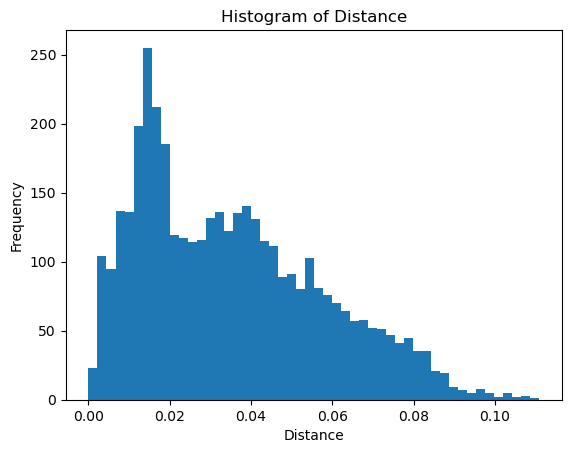

In [36]:

# Plotting the histogram
plt.hist(df_model_q1b['competitor_distance_wrt_AMY'], bins=50)  # Adjust the number of bins as needed
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distance')
plt.show()


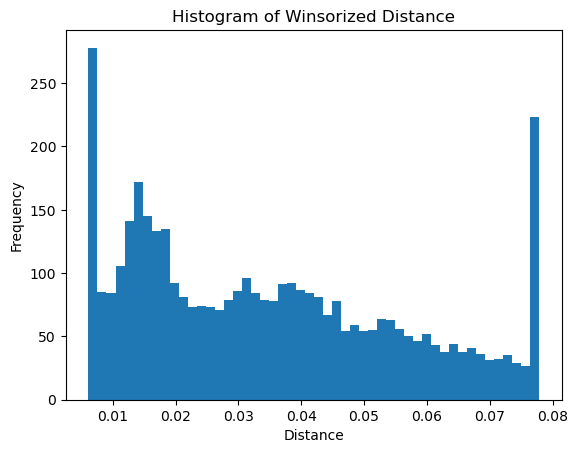

In [37]:
# Cuts out outliers and shows patterns in majority of the data
distances = df_model_q1b['competitor_distance_wrt_AMY']

# Apply Winsorization to limit extreme values
winsorized_distances = mstats.winsorize(distances, limits=[0.05, 0.05])

# Plotting the histogram with winsorized distances
plt.hist(winsorized_distances, bins=50)  # Adjust the number of bins as needed
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Winsorized Distance')
plt.show()


In [38]:
def get_top_competitors(df,n):

    lowest_scores = df['competitor_distance_wrt_AMY'].nsmallest(n, keep='first')
    lowest_indices = lowest_scores.index
    for index, score in zip(lowest_indices, lowest_scores):
        print(f"{data.loc[index]['listing_url']} ,Distance from Amy's-{round(df.loc[index]['distance_kms'],2)} kms, Competitor distance score: {round(100*score,6)}")
    return lowest_indices



In [39]:
print("\nAmy's competitors (by Clustering and scoring):\n")
top_competitors_index_a=get_top_competitors(df_model_q1a,11)
print("\nAmy's competitors (by direct scoring approach):\n")
top_competitors_index_b=get_top_competitors(df_model_q1b,11)


Amy's competitors (by Clustering and scoring):

https://www.airbnb.com/rooms/53274690 ,Distance from Amy's-0.0 kms, Competitor distance score: 0.0
https://www.airbnb.com/rooms/47891533 ,Distance from Amy's-0.09 kms, Competitor distance score: 0.054753
https://www.airbnb.com/rooms/51618903 ,Distance from Amy's-0.47 kms, Competitor distance score: 0.088994
https://www.airbnb.com/rooms/45763047 ,Distance from Amy's-0.03 kms, Competitor distance score: 0.152003
https://www.airbnb.com/rooms/45637885 ,Distance from Amy's-0.19 kms, Competitor distance score: 0.175249
https://www.airbnb.com/rooms/49860766 ,Distance from Amy's-0.75 kms, Competitor distance score: 0.225775
https://www.airbnb.com/rooms/52919151 ,Distance from Amy's-0.81 kms, Competitor distance score: 0.233152
https://www.airbnb.com/rooms/42064723 ,Distance from Amy's-0.09 kms, Competitor distance score: 0.248321
https://www.airbnb.com/rooms/44934927 ,Distance from Amy's-0.45 kms, Competitor distance score: 0.254426
https://www.

In [40]:
top_competitors_a = data.loc[top_competitors_index_a][["id","host_name","host_is_superhost","property_type","accommodates",
                          "bathrooms_text","bedrooms","beds","price","number_of_reviews","review_scores_rating"]]
top_competitors_b = data.loc[top_competitors_index_b][["id","host_name","host_is_superhost","property_type","accommodates",
                          "bathrooms_text","bedrooms","beds","price","number_of_reviews","review_scores_rating"]]

top_competitors_a

id host_name host_is_superhost     property_type  accommodates  \
5196  53274690       Amy                 t      Entire condo             8   
3905  47891533     Jason                 t       Entire loft            10   
4768  51618903      Luke                 t       Entire home             9   
3614  45763047      Tess                 t      Entire condo             6   
3592  45637885      Tess                 t      Entire condo             4   
4369  49860766     Jason                 t      Entire condo             3   
5110  52919151      Hoai                 f       Entire home             8   
3125  42064723     Mason                 t      Entire condo             4   
3528  44934927   Dorinda                 t  Entire townhouse            10   
4641  50988323   Stephen                 t       Entire home            12   
4437  50154599     Amber                 t  Entire townhouse             4   

     bathrooms_text  bedrooms  beds    price  number_of_reviews  \
5196         1 bath       2.0   6.0  $372.00                 63   
3905        2 baths       3.0   8.0  $319.00                 97   
4768      2.5 baths       3.0   5.0  $366.00                 34   
3614         1 bath       2.0   3.0  $262.00                 86   
3592         1 bath       1.0   2.0  $198.00                122   
4369         1 bath       1.0   1.0  $215.00                 32   
5110        2 baths       3.0   6.0  $200.00                 25   
3125         1 bath       1.0   2.0  $293.00                 53   
3528      2.5 baths       3.0   5.0  $280.00                 70   
4641        4 baths       4.0  12.0  $312.00                 33   
4437      2.5 baths       2.0   2.0  $161.00                 32   

      review_scores_rating  
5196                  5.00  
3905                  4.96  
4768                  4.97  
3614                  4.91  
3592                  4.93  
4369                  4.97  
5110                  4.60  
3125                  4.79  
3528                  4.76  
4641                  4.88  
4437                  4.91

In [41]:
top_competitors_b

id            host_name host_is_superhost property_type  \
5196            53274690                  Amy                 t  Entire condo   
5357            53768653        Jd And Bailey                 f   Entire loft   
4962            52556190  Music City Magnolia                 t  Entire condo   
3905            47891533                Jason                 t   Entire loft   
4681            51190718            StayLocal                 f   Entire home   
6063  578273828525601197              Stephen                 t   Entire home   
1206            20403799                Quynh                 t   Entire home   
4768            51618903                 Luke                 t   Entire home   
4733            51464632            StayLocal                 f   Entire home   
4244            49315530            StayLocal                 f   Entire home   
4923            52346766              Travers                 f   Entire home   

      accommodates bathrooms_text  bedrooms  beds    price  number_of_reviews  \
5196             8         1 bath       2.0   6.0  $372.00                 63   
5357             6         1 bath       1.0   3.0  $102.00                 69   
4962             6         1 bath       2.0   3.0  $200.00                 48   
3905            10        2 baths       3.0   8.0  $319.00                 97   
4681            11        2 baths       4.0   6.0  $206.00                 54   
6063            12      3.5 baths       4.0  11.0  $390.00                 25   
1206            10      2.5 baths       3.0   5.0  $340.00                 51   
4768             9      2.5 baths       3.0   5.0  $366.00                 34   
4733            10        2 baths       3.0   3.0  $328.00                 63   
4244             2         1 bath       1.0   1.0  $110.00                 60   
4923            12      3.5 baths       4.0   7.0  $512.00                 26   

      review_scores_rating  
5196                  5.00  
5357                  4.57  
4962                  4.98  
3905                  4.96  
4681                  4.70  
6063                  5.00  
1206                  5.00  
4768                  4.97  
4733                  4.76  
4244                  4.60  
4923                  4.96

In [42]:
top_competitors_a.to_csv("top_competitors_a.csv")
top_competitors_b.to_csv("top_competitors_b.csv")

In [43]:
#                                   X-------------X-------------X

##### ---- END OF Q1 ----

#### Q2 - Recommend an optimal nightly price for the next 90 days for this property.

In [44]:
# Stepwise forward regression to get the best features
def step_wise_regression(df_preprocessed, target_variable):
    df=df_preprocessed.copy()
    features = set(df.columns.tolist()) - set([target_variable])
    selected_features = []
    best_model = None
    best_aic = np.inf
    
    # Iterate over features to calculate individual R-squared scores and p-values
    feature_scores = []
    for feature in features:
        X = sm.add_constant(df[feature])
        model = sm.OLS(df[target_variable], X).fit()
        r2 = model.rsquared
        p_value = model.pvalues[1]  
        feature_scores.append((feature, r2, p_value))
    
    # Sort features based on R-squared score and p-value
    feature_scores.sort(key=lambda x: (x[1], x[2]), reverse=True)
    
    # Perform forward selection
    for feature, r2, p_value in feature_scores:
        selected_features.append(feature)
        X = sm.add_constant(df[selected_features])
        model = sm.OLS(df[target_variable], X).fit()
        aic = model.aic
        
        # Update the best model if the current model has lower AIC
        if aic < best_aic:
            best_model = model
            best_aic = aic
        else:
            # Remove the last feature if the current model does not improve AIC
            selected_features.pop()
        
        print(f"Selected feature: {feature}, R-squared: {r2}, P-value: {p_value}, AIC: {aic}")
    
    # Print the final selected features
    print("Final selected features:")
    print(selected_features)
    
    return selected_features



In [45]:
len(df_preprocessed.columns.tolist())

143

In [46]:
target='price'
selected_features=step_wise_regression(df_preprocessed,target)


Selected feature: bathrooms_text, R-squared: 0.4403756846508998, P-value: 0.0, AIC: 52289.186054677004
Selected feature: bedrooms, R-squared: 0.4370062326584272, P-value: 0.0, AIC: 52110.9953503931
Selected feature: accommodates, R-squared: 0.3933125749720785, P-value: 0.0, AIC: 52081.21644341543
Selected feature: beds, R-squared: 0.3384904554087448, P-value: 0.0, AIC: 52081.099813693865
Selected feature: washer, R-squared: 0.06356549857141247, P-value: 5.6585737245350345e-59, AIC: 52075.943125109436
Selected feature: room_type_Private room, R-squared: 0.05720458340222967, P-value: 4.418127033014411e-53, AIC: 52068.84439611778
Selected feature: distance_kms, R-squared: 0.055533164035429516, P-value: 1.539675926369126e-51, AIC: 51972.22275578897
Selected feature: competitor_distance_wrt_AMY, R-squared: 0.04775747143272102, P-value: 2.1336956762794085e-44, AIC: 51964.70329800277
Selected feature: number_of_reviews, R-squared: 0.046744609484792865, P-value: 1.8010067455447383e-43, AIC: 51

Selected feature: wifi, R-squared: 0.0011362475433026598, P-value: 0.03313001931903188, AIC: 51420.44874636922
Selected feature: Keypad, R-squared: 0.0011216225458201556, P-value: 0.03428185765261065, AIC: 51419.69375461601
Selected feature: Smoking allowed, R-squared: 0.0010691719285553791, P-value: 0.038769190347923504, AIC: 51415.117161044975
Selected feature: Children’s dinnerware, R-squared: 0.001050521587076081, P-value: 0.04050960191086445, AIC: 51416.39913939786
Selected feature: console, R-squared: 0.0010086359214119822, P-value: 0.044724145749552933, AIC: 51416.19934114728
Selected feature: bed, R-squared: 0.0009957104676844297, P-value: 0.04611593596099112, AIC: 51413.868721119914
Selected feature: gym, R-squared: 0.0009599198972717327, P-value: 0.05021332922701849, AIC: 51413.42194223862
Selected feature: Baby safety gates, R-squared: 0.0009135983642744039, P-value: 0.056095855709257986, AIC: 51414.415804965756
Selected feature: garden, R-squared: 0.0009078789032731516, P-v

In [47]:
df=df_preprocessed.copy()
features=selected_features
X = df[features]
y = df[target]
row_to_exclude = 5196


X_train, X_test, y_train, y_test = train_test_split(X.drop(row_to_exclude), y.drop(row_to_exclude), test_size=0.2, random_state=42)
row_data = X.loc[row_to_exclude, :]
X_test = X_test.append(row_data)
y_row = df.loc[row_to_exclude, target]
y_test = y_test.append(pd.Series(y_row))

xgb_reg = xgb.XGBRegressor()
cv_scores = cross_val_score(xgb_reg, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average Cross-Validation Score:", np.mean(cv_scores))
xgb_reg.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_test, y_test)])
importances = xgb_reg.feature_importances_

# Perform feature selection
# percentile = 75
threshold = 'median' #np.percentile(importances, percentile)

feature_selector = SelectFromModel(xgb_reg, threshold=threshold, prefit=True)
X_train_selected = feature_selector.transform(X_train)
X_test_selected = feature_selector.transform(X_test)

# Initialize and fit the XGBoost model with optimized hyperparameters
xgb_model = xgb.XGBRegressor(n_estimators=1500, learning_rate=0.05, max_depth=5, colsample_bytree=0.5)
xgb_model.fit(X_train_selected, y_train, early_stopping_rounds=10, eval_metric="rmse", eval_set=[(X_test_selected, y_test)])
y_pred = xgb_model.predict(X_test_selected)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
adjusted_r2 = 1 - ((1 - r2) * (len(X_test) - 1)) / (len(X_test) - len(features) - 1)

# Print the evaluation metrics
print('Root Mean Squared Error:', round(np.sqrt(mse),2))
print('R-squared:', r2)
print('Adjusted R-squared:', adjusted_r2)
    
selected_mask = feature_selector.get_support()
selected_features = np.array(features)[selected_mask]
print("\nSelected Features:", selected_features)


Cross-Validation Scores: [0.56556513 0.59714445 0.50143191 0.69278098 0.61149444]
Average Cross-Validation Score: 0.593683381481377
[0]	validation_0-rmse:294.23659
[1]	validation_0-rmse:235.39998
[2]	validation_0-rmse:196.17685
[3]	validation_0-rmse:172.89805
[4]	validation_0-rmse:157.17314
[5]	validation_0-rmse:148.43244
[6]	validation_0-rmse:143.46176
[7]	validation_0-rmse:138.96780
[8]	validation_0-rmse:137.64511
[9]	validation_0-rmse:136.50668
[10]	validation_0-rmse:135.80225
[11]	validation_0-rmse:135.73667
[12]	validation_0-rmse:135.00939
[13]	validation_0-rmse:134.40166
[14]	validation_0-rmse:133.39311
[15]	validation_0-rmse:133.20612
[16]	validation_0-rmse:133.09797
[17]	validation_0-rmse:132.16952
[18]	validation_0-rmse:131.93843
[19]	validation_0-rmse:131.19095
[20]	validation_0-rmse:131.24383
[21]	validation_0-rmse:131.29228
[22]	validation_0-rmse:130.79284
[23]	validation_0-rmse:130.41685
[24]	validation_0-rmse:130.30553
[25]	validation_0-rmse:130.06700
[26]	validation_0-rm

[201]	validation_0-rmse:126.61489
[202]	validation_0-rmse:126.62874
[203]	validation_0-rmse:126.65759
[204]	validation_0-rmse:126.64211
[205]	validation_0-rmse:126.61510
[206]	validation_0-rmse:126.56338
[207]	validation_0-rmse:126.57861
[208]	validation_0-rmse:126.51446
[209]	validation_0-rmse:126.46907
[210]	validation_0-rmse:126.47941
[211]	validation_0-rmse:126.46624
[212]	validation_0-rmse:126.46825
[213]	validation_0-rmse:126.47377
[214]	validation_0-rmse:126.47837
[215]	validation_0-rmse:126.42504
[216]	validation_0-rmse:126.42146
[217]	validation_0-rmse:126.42127
[218]	validation_0-rmse:126.43021
[219]	validation_0-rmse:126.43233
[220]	validation_0-rmse:126.39933
[221]	validation_0-rmse:126.40869
[222]	validation_0-rmse:126.38746
[223]	validation_0-rmse:126.41621
[224]	validation_0-rmse:126.36438
[225]	validation_0-rmse:126.32092
[226]	validation_0-rmse:126.32421
[227]	validation_0-rmse:126.23255
[228]	validation_0-rmse:126.23838
[229]	validation_0-rmse:126.23701
[230]	validati

In [48]:
# set(df.columns.tolist())-set(['price'])-set(selected_features)

In [49]:
index_location = np.where(X_test.index == 5196)
predicted_value = round(y_pred[index_location][0])
predicted_value

233

In [50]:
holiday=pd.read_excel("holiday.xlsx")
holiday=holiday[['Date', 'Day', 'weekend', 'weekday', 'long weekend', 'Holidays']]
holiday.drop('weekday',axis=1,inplace=True)

holiday.shape

(92, 5)

In [51]:
import re
from datetime import datetime
str1= "https://www.airbnb.com/rooms/"
str2="?category_tag=Tag%3A8173&adults=1&children=0&infants=0&check_in="
str3="&check_out="
str4="&federated_search_id=6174a078-a823-4fad-827a-7ca652b5e786&source_impression_id=p3_1645454076_foOVSAshSYvdbpbS"


# Function to extract the listing ID from the URL
def extract_listing_id(url, str1, str2):
    pattern = rf"{re.escape(str1)}(\d+){re.escape(str2)}"
    match = re.search(pattern, url)
    if match:
        return match.group(1)
    else:
        return None

# Function to extract the check-in date from the URL
def extract_checkin(url, str2, str3):
    pattern = rf"{re.escape(str2)}(\d{{4}}-\d{{2}}-\d{{2}}){re.escape(str3)}"
    match = re.search(pattern, url)
    if match:
        return datetime.strptime(match.group(1), '%Y-%m-%d').date()
    else:
        return None

# Function to extract the check-out date from the URL
def extract_checkout(url, str3, str4):
    pattern = rf"{re.escape(str3)}(\d{{4}}-\d{{2}}-\d{{2}}){re.escape(str4)}"
    match = re.search(pattern, url)
    if match:
        return datetime.strptime(match.group(1), '%Y-%m-%d').date()
    else:
        return None

#obtained this data by scraping airbnb website.
airbnb_price_trends=pd.read_csv("url_price2.csv") 
airbnb_price_trends.rename(columns={"Unnamed: 0": "url", "0": "price"}, inplace=True)
airbnb_price_trends['price'] = airbnb_price_trends['price'].astype(str).str.strip('[]').astype(float)
airbnb_price_trends['listing_id'] = airbnb_price_trends['url'].apply(lambda x: extract_listing_id(x, str1, str2))
airbnb_price_trends['checkin'] = airbnb_price_trends['url'].apply(lambda x: extract_checkin(x, str2, str3))
airbnb_price_trends['checkout'] = airbnb_price_trends['url'].apply(lambda x: extract_checkout(x, str3, str4))
airbnb_price_trends.drop('url', axis=1, inplace=True)
airbnb_price_trends = airbnb_price_trends[['listing_id', 'checkin', 'checkout', 'price']]

print(airbnb_price_trends.shape)
airbnb_price_trends.head()

(1001, 4)


listing_id     checkin    checkout  price
0   53274690  2023-07-01  2023-07-02  869.0
1   53274690  2023-07-02  2023-07-03  869.0
2   53274690  2023-07-03  2023-07-04  262.0
3   53274690  2023-07-04  2023-07-05    0.0
4   53274690  2023-07-05  2023-07-06  262.0

In [52]:
holiday.head()

Date  Day  weekend  long weekend  Holidays
0  01/07/2023  Sat        1             1         1
1  02/07/2023  Sun        1             1         1
2  03/07/2023  Mon        0             1         0
3  04/07/2023  Tue        0             1         1
4  05/07/2023  Wed        0             0         0

In [53]:
holiday['Date'] = pd.to_datetime(holiday['Date'], format='%d/%m/%Y')
airbnb_price_trends.reset_index(drop=True, inplace=True)
holiday.reset_index(drop=True, inplace=True)
airbnb_price_trends['checkin'] = pd.to_datetime(airbnb_price_trends['checkin'])

merged_df = airbnb_price_trends.merge(holiday, left_on='checkin',right_on='Date', how='left')
merged_df.shape

(1001, 9)

In [54]:
merged_df.head()

listing_id    checkin    checkout  price       Date  Day  weekend  \
0   53274690 2023-07-01  2023-07-02  869.0 2023-07-01  Sat        1   
1   53274690 2023-07-02  2023-07-03  869.0 2023-07-02  Sun        1   
2   53274690 2023-07-03  2023-07-04  262.0 2023-07-03  Mon        0   
3   53274690 2023-07-04  2023-07-05    0.0 2023-07-04  Tue        0   
4   53274690 2023-07-05  2023-07-06  262.0 2023-07-05  Wed        0   

   long weekend  Holidays  
0             1         1  
1             1         1  
2             1         0  
3             1         1  
4             0         0

In [55]:
import pandas as pd
import numpy as np

# Create an empty dictionary to store the average prices
weekday_avg_prices = {}
weekend_avg_prices = {}

# considering fridays as weekends
merged_df['weekend'] = (merged_df['Date'].dt.dayofweek >= 4).astype(int)


# Calculate average prices for each listing ID
for listing_id in merged_df['listing_id'].unique():
    listing_data = merged_df[merged_df['listing_id'] == listing_id]
    weekday_avg_prices[listing_id] = listing_data[listing_data['weekend'] == 0]['price'].mean()
    weekend_avg_prices[listing_id] = listing_data[listing_data['weekend'] == 1]['price'].mean()
modified_dfs=[]
# Iterate over each listing ID
for listing_id in merged_df['listing_id'].unique():
    # Filter data for the current listing ID
    listing_data = merged_df[merged_df['listing_id'] == listing_id]
    
    # Calculate the average prices for the current listing ID
    weekday_avg_price = weekday_avg_prices.get(listing_id, np.nan)
    weekend_avg_price = weekend_avg_prices.get(listing_id, np.nan)

    # Replace 0 values with the corresponding average price based on weekday or weekend
    listing_data.loc[(listing_data['price'] == 0) & (listing_data['weekend'] == 0), 'price'] = weekday_avg_price
    listing_data.loc[(listing_data['price'] == 0) & (listing_data['weekend'] == 1), 'price'] = weekend_avg_price
    
    # Create a list of all the modified DataFrames
    modified_dfs.append(listing_data)
# Merge all the DataFrames back together
merged_df = pd.concat(modified_dfs, axis=0,ignore_index=True)
merged_df = merged_df[merged_df['price']!=0]


    

In [56]:
merged_df.head()

listing_id    checkin    checkout       price       Date  Day  weekend  \
0   53274690 2023-07-01  2023-07-02  869.000000 2023-07-01  Sat        1   
1   53274690 2023-07-02  2023-07-03  869.000000 2023-07-02  Sun        1   
2   53274690 2023-07-03  2023-07-04  262.000000 2023-07-03  Mon        0   
3   53274690 2023-07-04  2023-07-05  309.326923 2023-07-04  Tue        0   
4   53274690 2023-07-05  2023-07-06  262.000000 2023-07-05  Wed        0   

   long weekend  Holidays  
0             1         1  
1             1         1  
2             1         0  
3             1         1  
4             0         0

In [57]:
merged_df.groupby('listing_id')['price'].mean()

listing_id
20403799    423.372288
47891533    460.125669
49315530    213.461538
51190718    586.329670
51464632    509.263736
51618903    520.041138
52346766    997.464074
52556190    232.039448
53274690    540.854396
Name: price, dtype: float64

In [58]:
#removing competitors without much data
competitor_df = merged_df[~merged_df['listing_id'].isin(['53274690'])]
df=merged_df[merged_df['listing_id']=='53274690']

In [59]:
listing_ids = merged_df['listing_id'].unique()

pc_inc ={}
for listing_id in listing_ids:
    listing_data = merged_df[merged_df['listing_id'] == listing_id]

    weekday_prices = listing_data[listing_data['weekend'] == 0]['price']
    weekend_prices = listing_data[listing_data['weekend'] == 1]['price']
    holiday_prices = listing_data[listing_data['Holidays'] == 1]['price']
    long_weekend_prices = listing_data[listing_data['long weekend'] == 1]['price']

    # Calculate average prices
    avg_weekday_price = weekday_prices.mean()
    avg_weekend_price = weekend_prices.mean()
    avg_holiday_price = holiday_prices.mean()
    avg_long_weekend_price = long_weekend_prices.mean()

    # Calculate percentage increase if weekday price is non-zero
    if avg_weekday_price != 0:
        percentage_increase = ((avg_weekend_price - avg_weekday_price) / avg_weekday_price) * 100
        pc_inc[listing_id]=round(percentage_increase)
    else:
        percentage_increase = 0
        pc_inc[listing_id]=0

    # Print results
    print(f"\nListing ID: {listing_id}")
    print("Average Weekday Price:", round(avg_weekday_price))
    print("Average Weekend Price:", round(avg_weekend_price))
    print("Average Holiday Price:", round(avg_holiday_price))
    print("Average Long Weekend Price:", round(avg_long_weekend_price))
    print("Percentage Increase:", round(percentage_increase))




Listing ID: 53274690
Average Weekday Price: 375
Average Weekend Price: 762
Average Holiday Price: 603
Average Long Weekend Price: 631
Percentage Increase: 103

Listing ID: 20403799
Average Weekday Price: 359
Average Weekend Price: 510
Average Holiday Price: 447
Average Long Weekend Price: 453
Percentage Increase: 42

Listing ID: 47891533
Average Weekday Price: 314
Average Weekend Price: 655
Average Holiday Price: 505
Average Long Weekend Price: 525
Percentage Increase: 109

Listing ID: 49315530
Average Weekday Price: 159
Average Weekend Price: 285
Average Holiday Price: 235
Average Long Weekend Price: 242
Percentage Increase: 79

Listing ID: 51190718
Average Weekday Price: 255
Average Weekend Price: 1028
Average Holiday Price: 723
Average Long Weekend Price: 759
Percentage Increase: 303

Listing ID: 51464632
Average Weekday Price: 229
Average Weekend Price: 883
Average Holiday Price: 625
Average Long Weekend Price: 656
Percentage Increase: 286

Listing ID: 51618903
Average Weekday Pri

In [60]:

pc_inc_sorted = dict(sorted(pc_inc.items(), key=lambda x: x[1]))
pc_inc_sorted

{'51618903': 27,
 '52556190': 29,
 '20403799': 42,
 '49315530': 79,
 '53274690': 103,
 '47891533': 109,
 '52346766': 162,
 '51464632': 286,
 '51190718': 303}

- In terms of avg % increase in weekend prices over weekday prices, Amy's property is right in the middle with over a 100% increase.

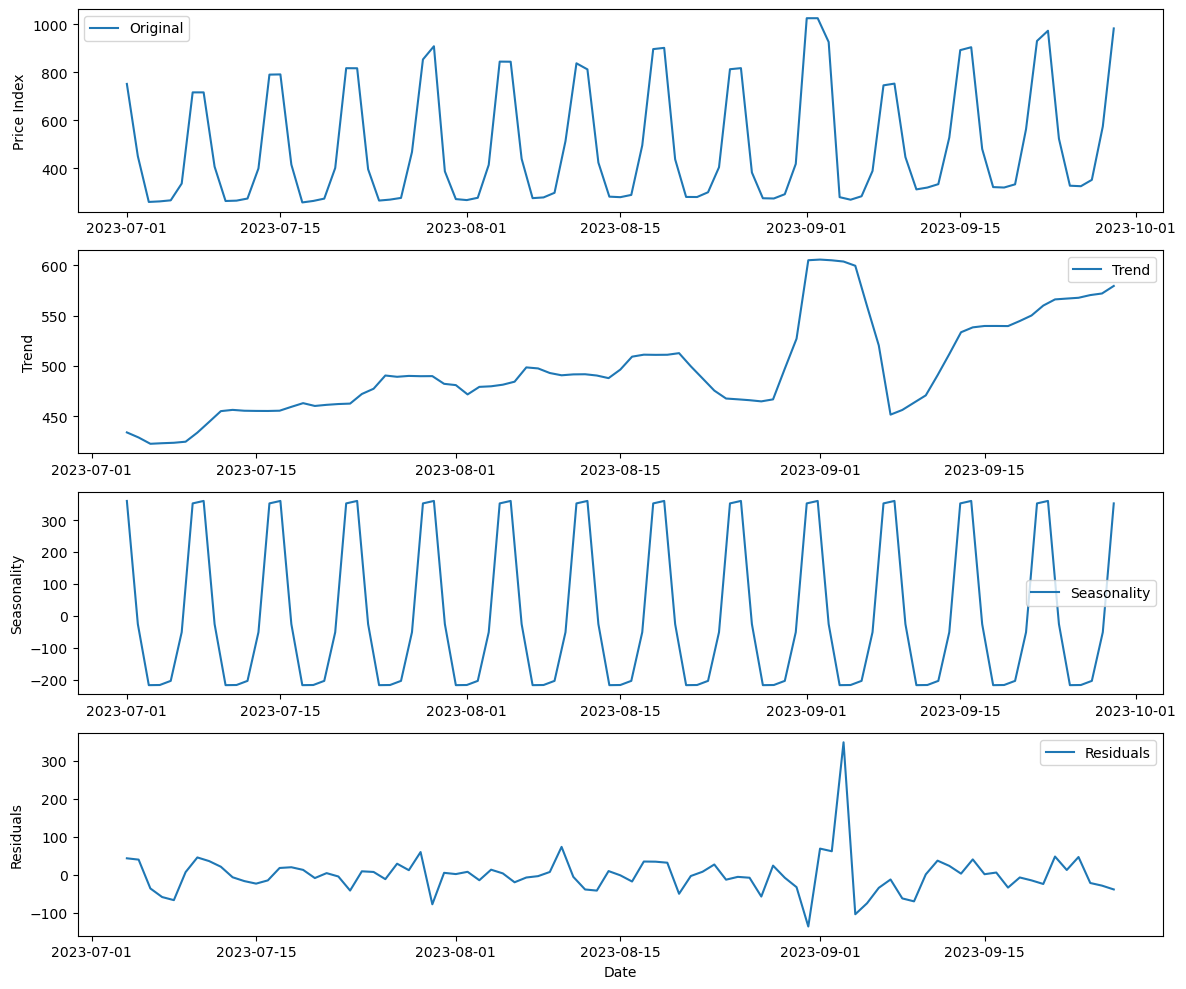

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Group the merged DataFrame by date and calculate the mean price index
price_indices = merged_df.groupby('Date')['price'].mean()

# Convert the price indices to a time series with a datetime index
price_indices_ts = pd.Series(price_indices.values, index=pd.to_datetime(price_indices.index))

# Decompose the time series to identify trend and seasonality components
decomposition = sm.tsa.seasonal_decompose(price_indices_ts, model='additive')

# Plot the decomposed components (trend, seasonality, residuals)
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

axes[0].plot(price_indices_ts, label='Original')
axes[0].legend(loc='best')
axes[0].set_ylabel('Price Index')

axes[1].plot(decomposition.trend, label='Trend')
axes[1].legend(loc='best')
axes[1].set_ylabel('Trend')

axes[2].plot(decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='best')
axes[2].set_ylabel('Seasonality')

axes[3].plot(decomposition.resid, label='Residuals')
axes[3].legend(loc='best')
axes[3].set_ylabel('Residuals')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


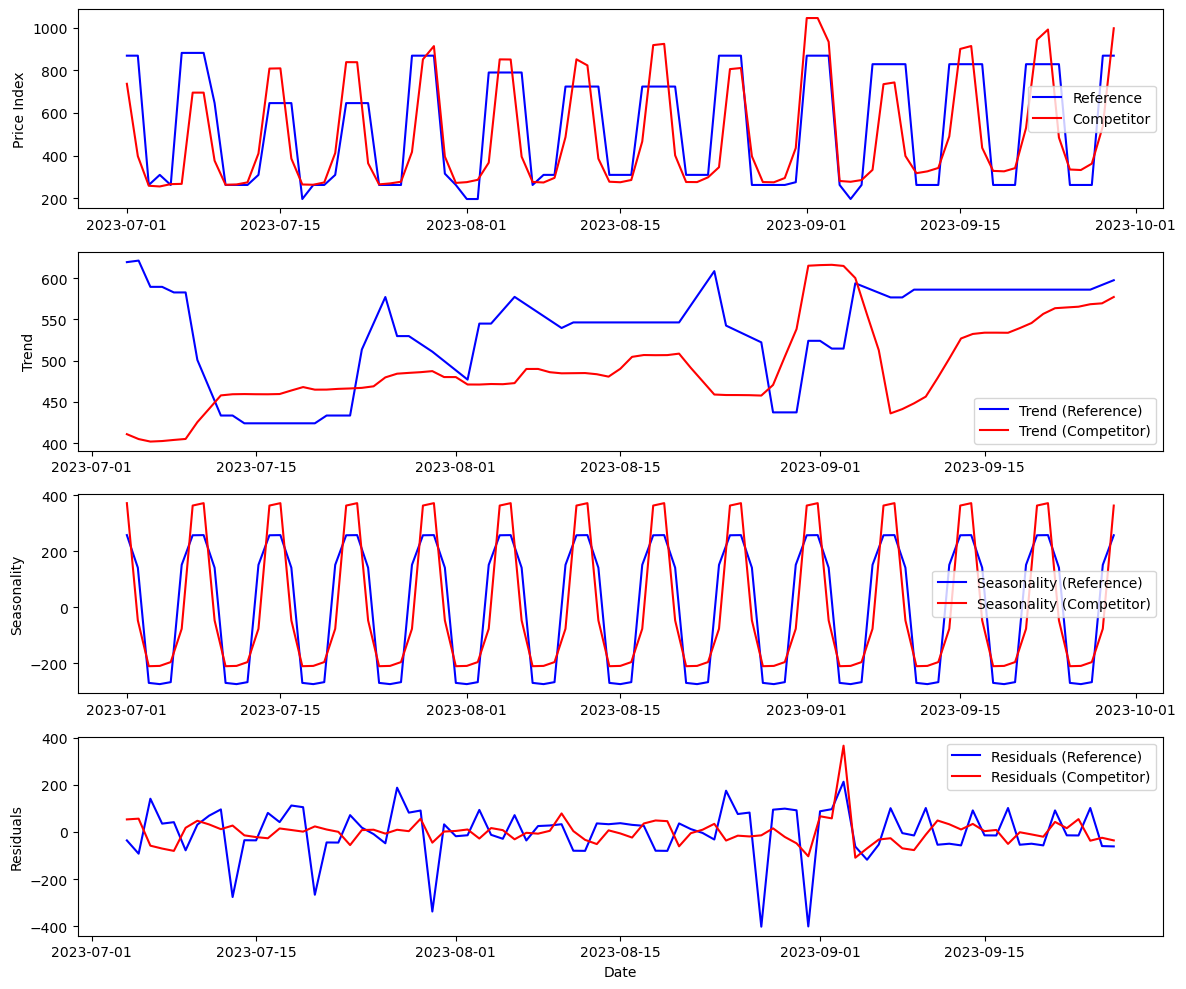

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Group the merged DataFrame by date and calculate the mean price index
reference_price_indices = df.groupby('Date')['price'].mean()
competitor_price_indices = competitor_df.groupby('Date')['price'].mean()

# Convert the price indices to a time series with a datetime index
reference_price_indices_ts = pd.Series(reference_price_indices.values, index=pd.to_datetime(reference_price_indices.index))
competitor_price_indices_ts = pd.Series(competitor_price_indices.values, index=pd.to_datetime(competitor_price_indices.index))

# Decompose the time series to identify trend and seasonality components for the reference data
reference_decomposition = sm.tsa.seasonal_decompose(reference_price_indices_ts, model='additive')

# Plot the decomposed components for the reference data
fig, axes = plt.subplots(4, 1, figsize=(12, 10))

axes[0].plot(reference_price_indices_ts, label='Reference', color='blue')
axes[0].legend(loc='best')
axes[0].set_ylabel('Price Index')

axes[1].plot(reference_decomposition.trend, label='Trend (Reference)', color='blue')
axes[1].legend(loc='best')
axes[1].set_ylabel('Trend')

axes[2].plot(reference_decomposition.seasonal, label='Seasonality (Reference)', color='blue')
axes[2].legend(loc='best')
axes[2].set_ylabel('Seasonality')

axes[3].plot(reference_decomposition.resid, label='Residuals (Reference)', color='blue')
axes[3].legend(loc='best')
axes[3].set_ylabel('Residuals')

# Decompose the time series to identify trend and seasonality components for the competitor data
competitor_decomposition = sm.tsa.seasonal_decompose(competitor_price_indices_ts, model='additive')

# Plot the decomposed components for the competitor data
axes[0].plot(competitor_price_indices_ts, label='Competitor', color='red')
axes[0].legend(loc='best')

axes[1].plot(competitor_decomposition.trend, label='Trend (Competitor)', color='red')
axes[1].legend(loc='best')

axes[2].plot(competitor_decomposition.seasonal, label='Seasonality (Competitor)', color='red')
axes[2].legend(loc='best')

axes[3].plot(competitor_decomposition.resid, label='Residuals (Competitor)', color='red')
axes[3].legend(loc='best')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [63]:
# Calculate average price increase for weekends (including Fridays)
weekend_increase = df.groupby(['listing_id', 'weekend'])['price'].mean().unstack().diff(axis=1)[1].mean()

# Print the average weekend price increase
print("Amy - Average Weekend Price Increase:", weekend_increase)


Amy - Average Weekend Price Increase: 387.55017258382645


In [64]:
# Calculate average price increase for weekends (including Fridays)
weekend_increase = competitor_df.groupby(['listing_id', 'weekend'])['price'].mean().unstack().diff(axis=1)[1].mean()

# Print the average weekend price increase
print("Competitor - Average Weekend Price Increase:", weekend_increase)

Competitor - Average Weekend Price Increase: 398.2562510272847


##### Insights based on time series analyis - 
- Trend can not be calculated as we have only 3 months of data. We need long term data for this.
- The seasonality graph shows a clear pattern of price hikes during weekends and drops in prices during weekdays. This indicates that there is a consistent weekend-related price increase trend across the analyzed time period.
- Comparison with Competitors: From the seasonality graph, it can be observed that Amy's property has lower price hikes during weekends compared to the competitors. This suggests that Amy's property may have a competitive advantage in terms of pricing during weekends and weekdays. 
- Both price index and price hikes are lower than the average. May be one of the reasons for high scores in review_score_value, as they are priced competitively

In [65]:

# Calculate the average competitor price for each day
competitor_avg_prices = competitor_df.groupby('Date')['price'].mean()

# Calculate the average Amy's price for each day
amy_avg_prices = df.groupby('Date')['price'].mean()

# Calculate the price differentials for each day
price_differentials = competitor_avg_prices - amy_avg_prices

# Create a new DataFrame to store the price differentials
price_diff_df = pd.DataFrame({'Date': price_differentials.index, 'Amy_prices': amy_avg_prices,"Competitor's prices":competitor_avg_prices,'Price_Differential': price_differentials.values})

In [66]:
price_diff_df.head()

Date  Amy_prices  Competitor's prices  Price_Differential
Date                                                                      
2023-07-01 2023-07-01  869.000000           736.929487         -132.070513
2023-07-02 2023-07-02  869.000000           397.339744         -471.660256
2023-07-03 2023-07-03  262.000000           258.250000           -3.750000
2023-07-04 2023-07-04  309.326923           254.985577          -54.341346
2023-07-05 2023-07-05  262.000000           265.860577            3.860577

In [67]:
comp=list(competitor_df["listing_id"].unique())
comp = [int(i) for i in comp]

In [68]:
original_index_amy=5196
transformed_index_amy = np.where(X_test.index == original_index_amy)
pred_price_amy = round(y_pred[transformed_index_amy][0])


In [69]:
original_index_c1=data[data.id.isin([52346766])].index.values[0]
transformed_index_c1 = np.where(X_test.index == original_index_c1)
pred_price_c1 = round(y_pred[transformed_index_c1][0])
original_index_c7=top_competitors_b[top_competitors_b.id.isin(comp)]
original_index_c7=list(original_index_c7.index)
transformed_index_c7 = [np.where(X_train.index==i)[0] for i in original_index_c7]
transformed_index_c7= [i[0] if i.size>0 else None for i in transformed_index_c7]
y_train_p=xgb_model.predict(X_train_selected)
pred_price_c7=[y_train_p[i] for i in transformed_index_c7][:7]
pred_price_c7.append(pred_price_c1)
mean_pred_c=round(np.mean(pred_price_c7))
pred_price_diff=mean_pred_c-pred_price_amy
pred_price_pc_diff=round(pred_price_diff/pred_price_amy,2)
pred_price_pc_diff
print(f'Predicted price of Amy - {pred_price_amy} and Mean predicted price of Top competitors - {mean_pred_c}')

print(f"All Competitors, put together, are valued on average at {100*pred_price_pc_diff}% more according to model")

Predicted price of Amy - 233 and Mean predicted price of Top competitors - 299
All Competitors, put together, are valued on average at 28.000000000000004% more according to model


In [70]:
comp_mean_90 = round(price_diff_df["Competitor's prices"].mean())
amy_mean_90 = round(price_diff_df["Amy_prices"].mean())
price_diff_df['competitor_scale_multiple'] = round((price_diff_df["Competitor's prices"] - comp_mean_90)/comp_mean_90,2)
price_diff_df['Amy_scale_multiple'] = round((price_diff_df["Amy_prices"] - amy_mean_90)/amy_mean_90,2)
print(f"Average price of Amy for the next 90 days : {amy_mean_90}; \n\
Average price of competitors for the next 90 days : {comp_mean_90}")
price_diff_df['recommended_multiple'] = np.where(price_diff_df['competitor_scale_multiple'] < price_diff_df['Amy_scale_multiple'], price_diff_df['competitor_scale_multiple'], (0.85)*price_diff_df['competitor_scale_multiple'])
price_diff_df.head()


Average price of Amy for the next 90 days : 541; 
Average price of competitors for the next 90 days : 493


Date  Amy_prices  Competitor's prices  Price_Differential  \
Date                                                                         
2023-07-01 2023-07-01  869.000000           736.929487         -132.070513   
2023-07-02 2023-07-02  869.000000           397.339744         -471.660256   
2023-07-03 2023-07-03  262.000000           258.250000           -3.750000   
2023-07-04 2023-07-04  309.326923           254.985577          -54.341346   
2023-07-05 2023-07-05  262.000000           265.860577            3.860577   

            competitor_scale_multiple  Amy_scale_multiple  \
Date                                                        
2023-07-01                       0.49                0.61   
2023-07-02                      -0.19                0.61   
2023-07-03                      -0.48               -0.52   
2023-07-04                      -0.48               -0.43   
2023-07-05                      -0.46               -0.52   

            recommended_multiple  
Date                              
2023-07-01                 0.490  
2023-07-02                -0.190  
2023-07-03                -0.408  
2023-07-04                -0.480  
2023-07-05                -0.391

In [71]:
inflation_factor_c = round((comp_mean_90-mean_pred_c)/mean_pred_c,2)
inflation_factor_amy = round((amy_mean_90-pred_price_amy)/pred_price_amy,2)
inf_factor = np.mean([inflation_factor_amy, inflation_factor_c])

print("price increase factor since data was collected to present date:",inf_factor)


price increase factor since data was collected to present date: 0.9850000000000001


In [72]:
amys_baseline = pred_price_amy*(1+inf_factor)
amys_baseline

462.505

In [73]:
price_diff_df["recommended_price"]=round(amys_baseline*(1+price_diff_df["recommended_multiple"]))
price_diff_df.head()

Date  Amy_prices  Competitor's prices  Price_Differential  \
Date                                                                         
2023-07-01 2023-07-01  869.000000           736.929487         -132.070513   
2023-07-02 2023-07-02  869.000000           397.339744         -471.660256   
2023-07-03 2023-07-03  262.000000           258.250000           -3.750000   
2023-07-04 2023-07-04  309.326923           254.985577          -54.341346   
2023-07-05 2023-07-05  262.000000           265.860577            3.860577   

            competitor_scale_multiple  Amy_scale_multiple  \
Date                                                        
2023-07-01                       0.49                0.61   
2023-07-02                      -0.19                0.61   
2023-07-03                      -0.48               -0.52   
2023-07-04                      -0.48               -0.43   
2023-07-05                      -0.46               -0.52   

            recommended_multiple  recommended_price  
Date                                                 
2023-07-01                 0.490              689.0  
2023-07-02                -0.190              375.0  
2023-07-03                -0.408              274.0  
2023-07-04                -0.480              241.0  
2023-07-05                -0.391              282.0

In [74]:
print("Recommended prices for Amy's property for the next 90 days: \n\n",price_diff_df.recommended_price)

Recommended prices for Amy's property for the next 90 days: 

 Date
2023-07-01    689.0
2023-07-02    375.0
2023-07-03    274.0
2023-07-04    241.0
2023-07-05    282.0
2023-07-06    250.0
2023-07-07    652.0
2023-07-08    652.0
2023-07-09    352.0
2023-07-10    278.0
2023-07-11    282.0
2023-07-12    290.0
2023-07-13    396.0
2023-07-14    714.0
2023-07-15    714.0
2023-07-16    361.0
2023-07-17    282.0
2023-07-18    278.0
2023-07-19    290.0
2023-07-20    400.0
2023-07-21    738.0
2023-07-22    738.0
2023-07-23    342.0
2023-07-24    282.0
2023-07-25    286.0
2023-07-26    290.0
2023-07-27    393.0
2023-07-28    749.0
2023-07-29    797.0
2023-07-30    384.0
2023-07-31    286.0
2023-08-01    290.0
2023-08-02    297.0
2023-08-03    342.0
2023-08-04    749.0
2023-08-05    749.0
2023-08-06    370.0
2023-08-07    290.0
2023-08-08    254.0
2023-08-09    305.0
2023-08-10    458.0
2023-08-11    749.0
2023-08-12    726.0
2023-08-13    361.0
2023-08-14    259.0
2023-08-15    259.0
2023-08-16  

In [101]:
final=price_diff_df[["recommended_price"]]
final.to_csv("Price recommendations for Amy's Listing.csv")

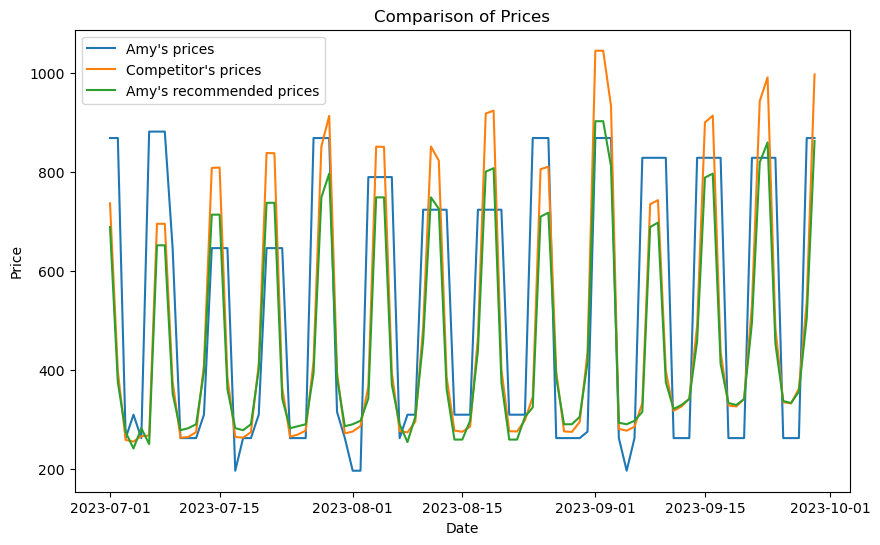

In [75]:
import matplotlib.pyplot as plt

dates = price_diff_df.index
amy_prices = price_diff_df['Amy_prices']
competitor_prices = price_diff_df["Competitor's prices"]
recommended_prices = price_diff_df['recommended_price']

plt.figure(figsize=(10, 6))
plt.plot(dates, amy_prices, label="Amy's prices")
plt.plot(dates, competitor_prices, label="Competitor's prices")
plt.plot(dates, recommended_prices, label="Amy's recommended prices")
plt.title("Comparison of Prices")
plt.xlabel("Date")
plt.ylabel("Price")

plt.legend()
plt.show()


##### ---- END OF Q2 -----

#### Q3. This property is a high-converting property & in the top 1% of properties in the city. What are some features that might make this property perform in the top 1%?

In [76]:
df_preprocessed = pd.read_csv("Nashville_property_listings_data_preprocessed.csv",index_col="Unnamed: 0")
df_preprocessed.head()

id  host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  \
1    39870                1.0             2             1.0       1.0   1.0   
3    72906                1.0             2             1.0       2.0   2.0   
7   329997                1.0             2             1.0       1.0   1.0   
9   395889                1.0             2             1.0       1.0   1.0   
10  421290                1.0             2             1.0       1.0   1.0   

    price  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
1    72.0                328                     64                       5   
3   105.0                658                     56                       5   
7   111.0               1197                    110                       9   
9    95.0                294                     38                       3   
10  106.0                948                     74                       4   

    review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
1                   4.94                    4.96                       4.95   
3                   4.91                    4.90                       4.81   
7                   4.89                    4.92                       4.93   
9                   4.86                    4.95                       4.93   
10                  4.95                    4.97                       4.98   

    review_scores_checkin  review_scores_communication  \
1                    4.98                         4.97   
3                    4.98                         4.99   
7                    4.94                         4.94   
9                    4.96                         4.96   
10                   4.97                         4.96   

    review_scores_location  review_scores_value  number_of_months_old  \
1                     4.95                 4.94                 158.0   
3                     4.96                 4.89                 157.0   
7                     4.58                 4.88                 139.0   
9                     4.69                 4.81                 140.0   
10                    4.80                 4.94                 139.0   

    distance_kms  room_type_Hotel room  room_type_Private room  \
1       3.842908                     0                       1   
3       3.159843                     0                       0   
7       1.917242                     0                       0   
9       5.040639                     0                       1   
10      1.873417                     0                       0   

    room_type_Shared room  gym  Concierge  Ski-in/Ski-out  \
1                       0    0          0               0   
3                       0    0          0               0   
7                       0    0          0               0   
9                       0    0          0               0   
10                      0    0          0               0   

    Bathroom essentials  Bidet  Cleaning products  Sound  EV charger  \
1                     0      0                  0      0           0   
3                     0      0                  0      0           0   
7                     0      0                  0      0           0   
9                     0      0                  0      0           0   
10                    0      0                  1      0           0   

    Smoking allowed  Self check-in  alarm  Piano  Mini fridge  \
1                 0              0      1      0            0   
3                 0              0      1      0            0   
7                 0              0      1      0            0   
9                 0              0      1      0            0   
10                0              0      1      0            1   

    Air conditioning  First aid kit  Essentials  Heating  \
1                  1              0           1        1   
3                  1              1           1        1   
7                  0       

In [77]:
df_preprocessed.drop(["id"],axis=1,inplace=True)

##### 
We know Amy's listing is in the top 1 %ile. Analysing & Identifying features where her property outperforms the rest

In [78]:

def get_top1percentile_features(df_preprocessed):
    
    df=df_preprocessed.copy()
    
    # Amy's  listing 
    reference_listing = df.loc[5196]

    # Calculate the threshold value for each column
    thresholds = df.quantile(0.99)

    # Loop through each column and check if the reference listing value exceeds the threshold
    top_1_percent_features = []
    for column in df.columns:
        if reference_listing[column] >= thresholds[column]:
            top_1_percent_features.append(column)    
    
    return top_1_percent_features

top_1_percent_features=get_top1percentile_features(df_preprocessed)

print("Features where the Amy's listing falls in the top 1%ile:\n\n",top_1_percent_features)


Features where the Amy's listing falls in the top 1%ile:

 ['host_is_superhost', 'review_scores_rating', 'room_type_Hotel room', 'room_type_Shared room', 'gym', 'Concierge', 'Ski-in/Ski-out', 'Bidet', 'Cleaning products', 'Sound', 'Smoking allowed', 'alarm', 'Air conditioning', 'Essentials', 'Heating', 'Host greets you', 'Pets allowed', 'TV', 'parking', 'BBQ grill', 'Lake access', 'Long term stays allowed', 'Free carport', 'Freezer', 'Private entrance', 'Microwave', 'Boat slip', 'Beach essentials', 'Dedicated workspace', 'Cooking basics', 'stove', 'washer', 'Iron', 'kitchen', 'pool', 'soap', 'garage', 'Dining table', 'Outdoor shower', 'Ethernet connection', 'Outdoor furniture', 'Airport shuttle', 'Wine glasses', 'Babysitter recommendations', 'Clothing storage', 'wifi', 'Hot water', 'coffee', 'Baking sheet', 'Housekeeping', 'Shared sauna', 'Toiletries', 'Mosquito net', 'refrigerator', 'dryer', 'Restaurant', 'Hangers', 'bed', 'Portable heater', 'Suitable for events', 'Table corner guards

#### 
- On analyzing the features,we find that Amy's listing falls in the top 1% for this feature - review_scores_rating;
- The USP for Amy's listing is the ratings which the customer leaves after their experience of staying in the property

In [79]:
# Filter the dataset to include only top 1% listings based on price
thresholds = df_preprocessed.quantile(0.99)

top_1_percent_listings = df_preprocessed[df_preprocessed['review_scores_rating'] >= thresholds['review_scores_rating']]
top_1_percent_listings.shape

(755, 142)

In [80]:
top_1_percent_listings.head()

host_is_superhost  accommodates  bathrooms_text  bedrooms  beds  price  \
46                 0.0             1             1.0       1.0   1.0  104.0   
53                 0.0             6             3.0       3.0   3.0  550.0   
80                 0.0             9             3.5       4.0   5.0  312.0   
81                 0.0             4             1.0       1.0   2.0  325.0   
139                1.0             8             2.0       2.0   2.0  324.0   

     number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  \
46                   2                      0                       0   
53                   8                      1                       0   
80                  18                      8                       0   
81                  10                      3                       1   
139                 17                      2                       0   

     review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
46                    5.0                    5.00                       5.00   
53                    5.0                    4.86                       4.86   
80                    5.0                    5.00                       5.00   
81                    5.0                    5.00                       5.00   
139                   5.0                    5.00                       5.00   

     review_scores_checkin  review_scores_communication  \
46                     5.0                         5.00   
53                     5.0                         4.86   
80                     5.0                         5.00   
81                     5.0                         5.00   
139                    5.0                         5.00   

     review_scores_location  review_scores_value  number_of_months_old  \
46                     5.00                 4.50                 121.0   
53                     5.00                 4.86                 150.0   
80                     4.94                 4.88                 111.0   
81                     5.00                 4.90                 112.0   
139                    4.82                 5.00                 113.0   

     distance_kms  room_type_Hotel room  room_type_Private room  \
46       2.126483                     0                       0   
53       2.733557                     0                       0   
80       4.137828                     0                       0   
81       5.168168                     0                       0   
139      5.853065                     0                       0   

     room_type_Shared room  gym  Concierge  Ski-in/Ski-out  \
46                       1    0          0               0   
53                       0    0          0               0   
80                       0    0          0               0   
81                       0    0          0               0   
139                      0    0          0               0   

     Bathroom essentials  Bidet  Cleaning products  Sound  EV charger  \
46                     0      0                  0      0           0   
53                     0      0                  0      0           0   
80                     0      0                  0      0           1   
81                     0      0                  1      1           1   
139                    0      0                  0      0           0   

     Smoking allowed  Self check-in  alarm  Piano  Mini fridge  \
46                 0              0      1      0            0   
53                 0              0      0      0            0   
80                 0              0      1      0            0   
81                 0              0      1      1            0   
139                0              0      1      0            0   

     Air conditioning  First aid kit  Essentials  Heating  \
46                  1              1           1        1   
53                  1              0           1        1   
80             

In [81]:
top_1_percent_listings['review_scores_rating'].value_counts()

5.0    755
Name: review_scores_rating, dtype: int64

In [82]:
top_1_percent_listings.describe()

host_is_superhost  accommodates  bathrooms_text    bedrooms  \
count         755.000000    755.000000      755.000000  755.000000   
mean            0.619868      8.098013        2.737748    2.969536   
std             0.485741      4.148559        1.820373    1.807111   
min             0.000000      1.000000        1.000000    1.000000   
25%             0.000000      4.000000        1.000000    2.000000   
50%             1.000000      8.000000        2.500000    3.000000   
75%             1.000000     12.000000        3.500000    4.000000   
max             1.000000     16.000000       16.000000   16.000000   

             beds        price  number_of_reviews  number_of_reviews_ltm  \
count  755.000000   755.000000         755.000000             755.000000   
mean     5.426490   370.203974          21.104636              11.109934   
std      4.533499   307.469294          37.840141              13.457856   
min      1.000000    31.000000           1.000000               0.000000   
25%      2.000000   180.500000           3.000000               2.000000   
50%      4.000000   278.000000          10.000000               6.000000   
75%      7.000000   460.500000          23.000000              16.000000   
max     40.000000  3300.000000         561.000000              81.000000   

       number_of_reviews_l30d  review_scores_rating  review_scores_accuracy  \
count              755.000000                 755.0              755.000000   
mean                 1.398675                   5.0                4.976040   
std                  1.681937                   0.0                0.084051   
min                  0.000000                   5.0                4.000000   
25%                  0.000000                   5.0                5.000000   
50%                  1.000000                   5.0                5.000000   
75%                  2.000000                   5.0                5.000000   
max                 11.000000                   5.0                5.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                 755.000000             755.000000   
mean                    4.950172               4.970795   
std                     0.132934               0.112728   
min                     4.000000               4.000000   
25%                     4.960000               5.000000   
50%                     5.000000               5.000000   
75%                     5.000000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                   755.000000              755.000000   
mean                      4.985828                4.882517   
std                       0.074433                0.226200   
min                       4.000000                3.000000   
25%                       5.000000                4.860000   
50%                       5.000000                4.980000   
75%                       5.000000                5.000000   
max                       5.000000                5.000000   

       review_scores_value  number_of_months_old  distance_kms  \
count           755.000000            755.000000    755.000000   
mean              4.916543             82.413245      5.468100   
std               0.145055             33.159631      4.359307   
min               3.500000             10.000000      0.000000   
25%               4.880000             60.500000      2.710243   
50%               4.970000             85.000000      4.605314   
75%               5.000000            105.000000      6.443561   
max               5.000000            176.000000     27.359259   

       room_type_Hotel room  room_type_Private room  room_type_Shared room  \
count            755.000000              755.000000             755.000000   
mean               0.015894                0.092715               0.001325   
std                0.125149                0.290225        

In [83]:
df_preprocessed.describe()

host_is_superhost  accommodates  bathrooms_text     bedrooms  \
count        3995.000000   3995.000000     3995.000000  3995.000000   
mean            0.643805      7.138673        2.178723     2.500375   
std             0.478934      3.761451        1.428210     1.459583   
min             0.000000      1.000000        0.000000     1.000000   
25%             0.000000      4.000000        1.000000     1.000000   
50%             1.000000      6.000000        2.000000     2.000000   
75%             1.000000     10.000000        3.000000     3.000000   
max             1.000000     16.000000       16.000000    16.000000   

              beds        price  number_of_reviews  number_of_reviews_ltm  \
count  3995.000000  3995.000000        3995.000000            3995.000000   
mean      4.527409   285.494618          90.727159              28.796746   
std       3.770711   224.810871         114.257443              28.713820   
min       1.000000    25.000000           1.000000               0.000000   
25%       2.000000   147.000000          19.000000               9.000000   
50%       3.000000   225.000000          52.000000              23.000000   
75%       6.000000   348.500000         117.500000              41.000000   
max      40.000000  3300.000000        1197.000000             768.000000   

       number_of_reviews_l30d  review_scores_rating  review_scores_accuracy  \
count             3995.000000           3995.000000             3995.000000   
mean                 2.133417              4.849314                4.885870   
std                  2.930333              0.207102                0.191475   
min                  0.000000              2.000000                1.000000   
25%                  0.000000              4.800000                4.860000   
50%                  2.000000              4.910000                4.940000   
75%                  3.000000              4.970000                4.990000   
max                114.000000              5.000000                5.000000   

       review_scores_cleanliness  review_scores_checkin  \
count                3995.000000            3995.000000   
mean                    4.828741               4.915630   
std                     0.219264               0.174848   
min                     2.000000               1.000000   
25%                     4.760000               4.900000   
50%                     4.890000               4.970000   
75%                     4.970000               5.000000   
max                     5.000000               5.000000   

       review_scores_communication  review_scores_location  \
count                  3995.000000             3995.000000   
mean                      4.917399                4.806638   
std                       0.167394                0.243589   
min                       1.000000                2.670000   
25%                       4.900000                4.750000   
50%                       4.970000                4.880000   
75%                       5.000000                4.950000   
max                       5.000000                5.000000   

       review_scores_value  number_of_months_old  distance_kms  \
count          3995.000000           3995.000000   3995.000000   
mean              4.801892             85.220025      5.412146   
std               0.207894             29.449734      4.340395   
min               2.000000             10.000000      0.000000   
25%               4.740000             70.000000      2.590421   
50%               4.850000             85.000000      4.224433   
75%               4.920000            104.000000      6.657845   
max               5.000000            176.000000     27.359259   

       room_type_Hotel room  room_type_Private room  room_type_Shared room  \
count           3995.000000             3995.000000            3995.000000   
mean               0.005507                0.093367               0.000501   
std                0.074013              

In [84]:
import seaborn as sns
import numpy as np
    
def plots_(df_preprocessed, top_1_percent_listings, features):
    df = df_preprocessed.copy()
    rest_listings = df.drop(top_1_percent_listings.index)
    
    num_rows = math.ceil(len(features) / 2)
    num_cols = 2
    fig_width = num_cols * 8
    fig_height = num_rows * 3.5
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(fig_width, fig_height), sharey=False)
    axes = axes.reshape(num_rows, num_cols)

    for i, column in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        ax = axes[row, col]

        # Check if the column is an integer (discrete variable)
        if df[column].dtype == 'int64':
            categories = sorted(df[column].unique())
            num_categories = len(categories)

            # Calculate proportions for each category
            top_1_percent_counts = top_1_percent_listings[column].value_counts().sort_index()
            rest_counts = rest_listings[column].value_counts().sort_index()

            # Align categories for top 1% and rest listings
            aligned_top_1_percent_counts = top_1_percent_counts.reindex(categories, fill_value=0)
            aligned_rest_counts = rest_counts.reindex(categories, fill_value=0)

            top_1_percent_proportions = aligned_top_1_percent_counts / aligned_top_1_percent_counts.sum()
            rest_proportions = aligned_rest_counts / aligned_rest_counts.sum()

            # Plotting barplot for proportions
            bar_width = 0.35
            index = np.arange(num_categories)

            ax.bar(index, top_1_percent_proportions, width=bar_width, color='blue', label='Top 1% Listings')
            ax.bar(index + bar_width, rest_proportions, width=bar_width, color='orange', label='Rest of the Listings', alpha=0.7, hatch='//')

            ax.set_xlabel(column)
            ax.set_ylabel('Proportion')
            ax.set_title(f'Proportion of {column}')
            ax.set_xticks(index + bar_width / 2)
            ax.set_xticklabels(categories)
            ax.legend()


        # Check if the column is a float (continuous variable)
        elif df[column].dtype == 'float64':
            sns.histplot(data=top_1_percent_listings, x=column, kde=True, color='blue', label='Top 1% Listings', stat='density', ax=ax)
            sns.histplot(data=rest_listings, x=column, kde=True, color='orange', label='Rest of the Listings', stat='density', ax=ax)
            ax.set_xlabel(column)
            ax.set_ylabel('Density')
            ax.set_title(f'Distribution of {column}')
            ax.legend()

    fig.suptitle('Feature Analysis', y=1.02)
    plt.tight_layout()        
    plt.show()


In [85]:
to_convert=['host_is_superhost','accommodates','bathrooms_text','bedrooms','beds']

for i in to_convert:
    df_preprocessed[i]=df_preprocessed[i].astype('int')             
    top_1_percent_listings[i]=top_1_percent_listings[i].astype('int')

to_convert_=['number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d','total_amenities']
for i in to_convert_:
    df_preprocessed[i]=df_preprocessed[i].astype('float')             
    top_1_percent_listings[i]=top_1_percent_listings[i].astype('float')

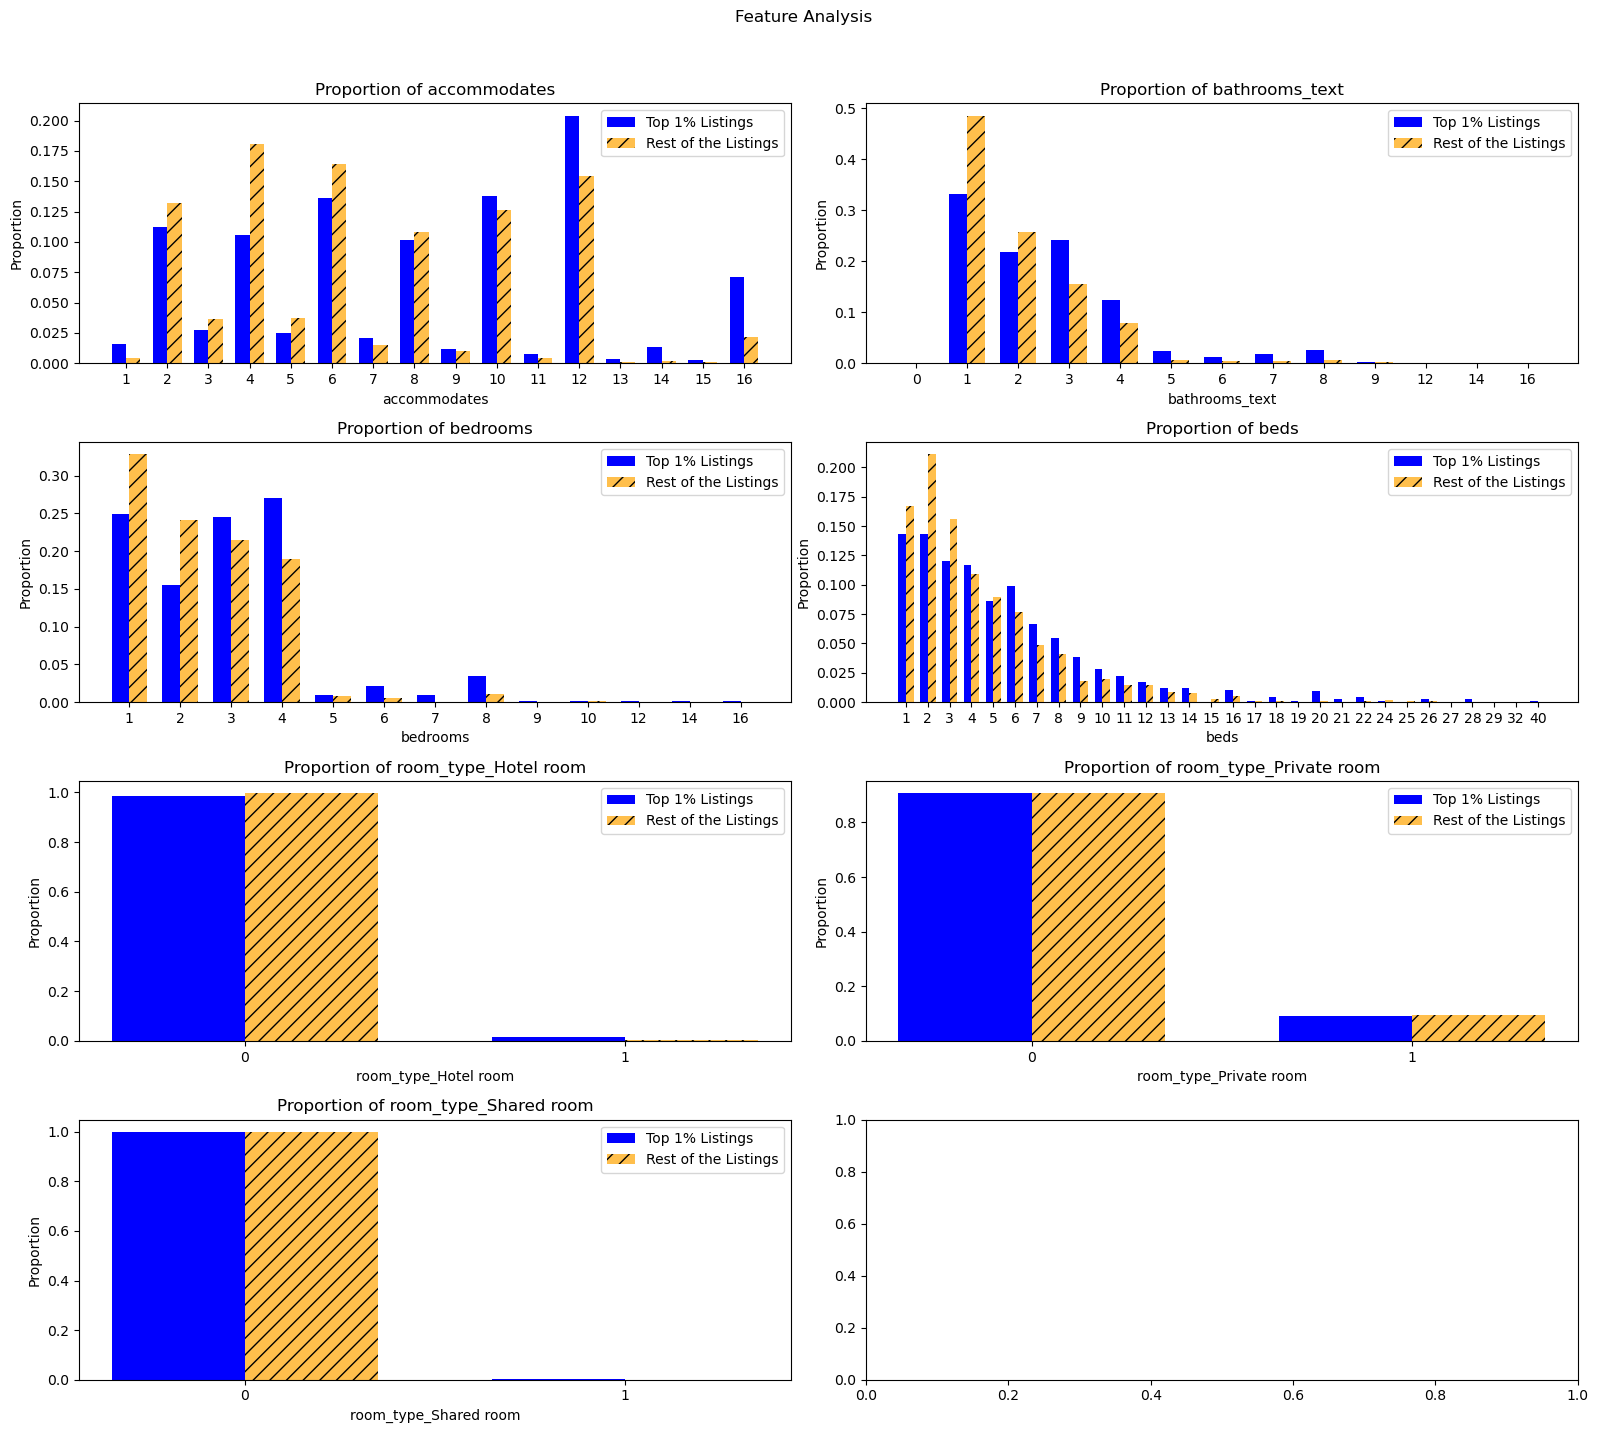

In [86]:
plots_(df_preprocessed,top_1_percent_listings,basic_requirement)


#### Insights about Top 1 % Listings (by review_score_rating)
- High proportion of these listings have more than 3 bathrooms and 3 bedrooms
- High proportion of these listings accommodate large groups of people than the rest
- High proportion of these listings have 6 or more beds

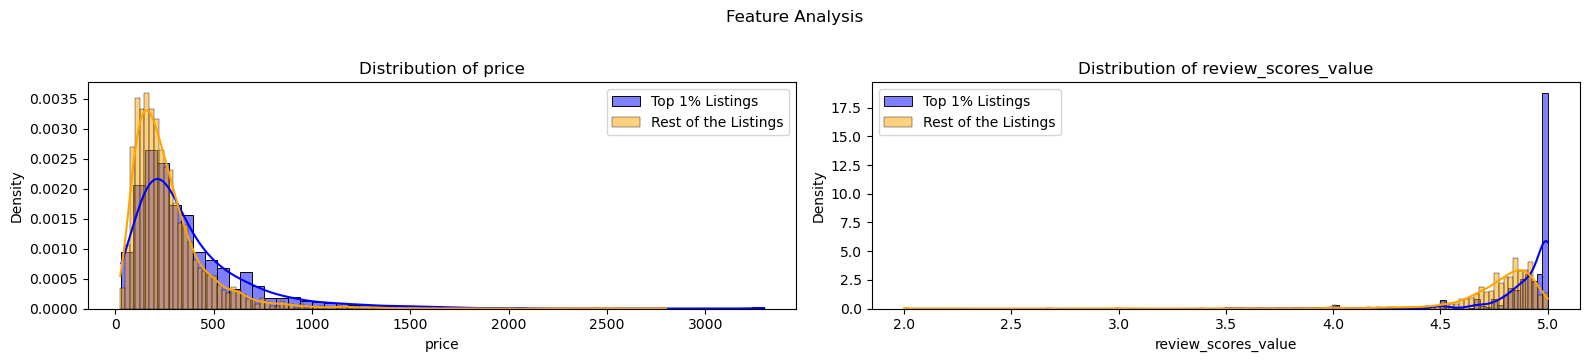

In [87]:
plots_(df_preprocessed,top_1_percent_listings,value)


#### Insights about Top 1 % Listings (by review_score_rating)
- Price distribution for top listings show fatter right tails compared to the rest, implies higher proportion of premium listings compared to the rest.
- Distribution of review_scores_value indicates very high proportion of the top listings manage to get rated very highly on the value for price metric.Indicates people see value for the premium price they pay for.

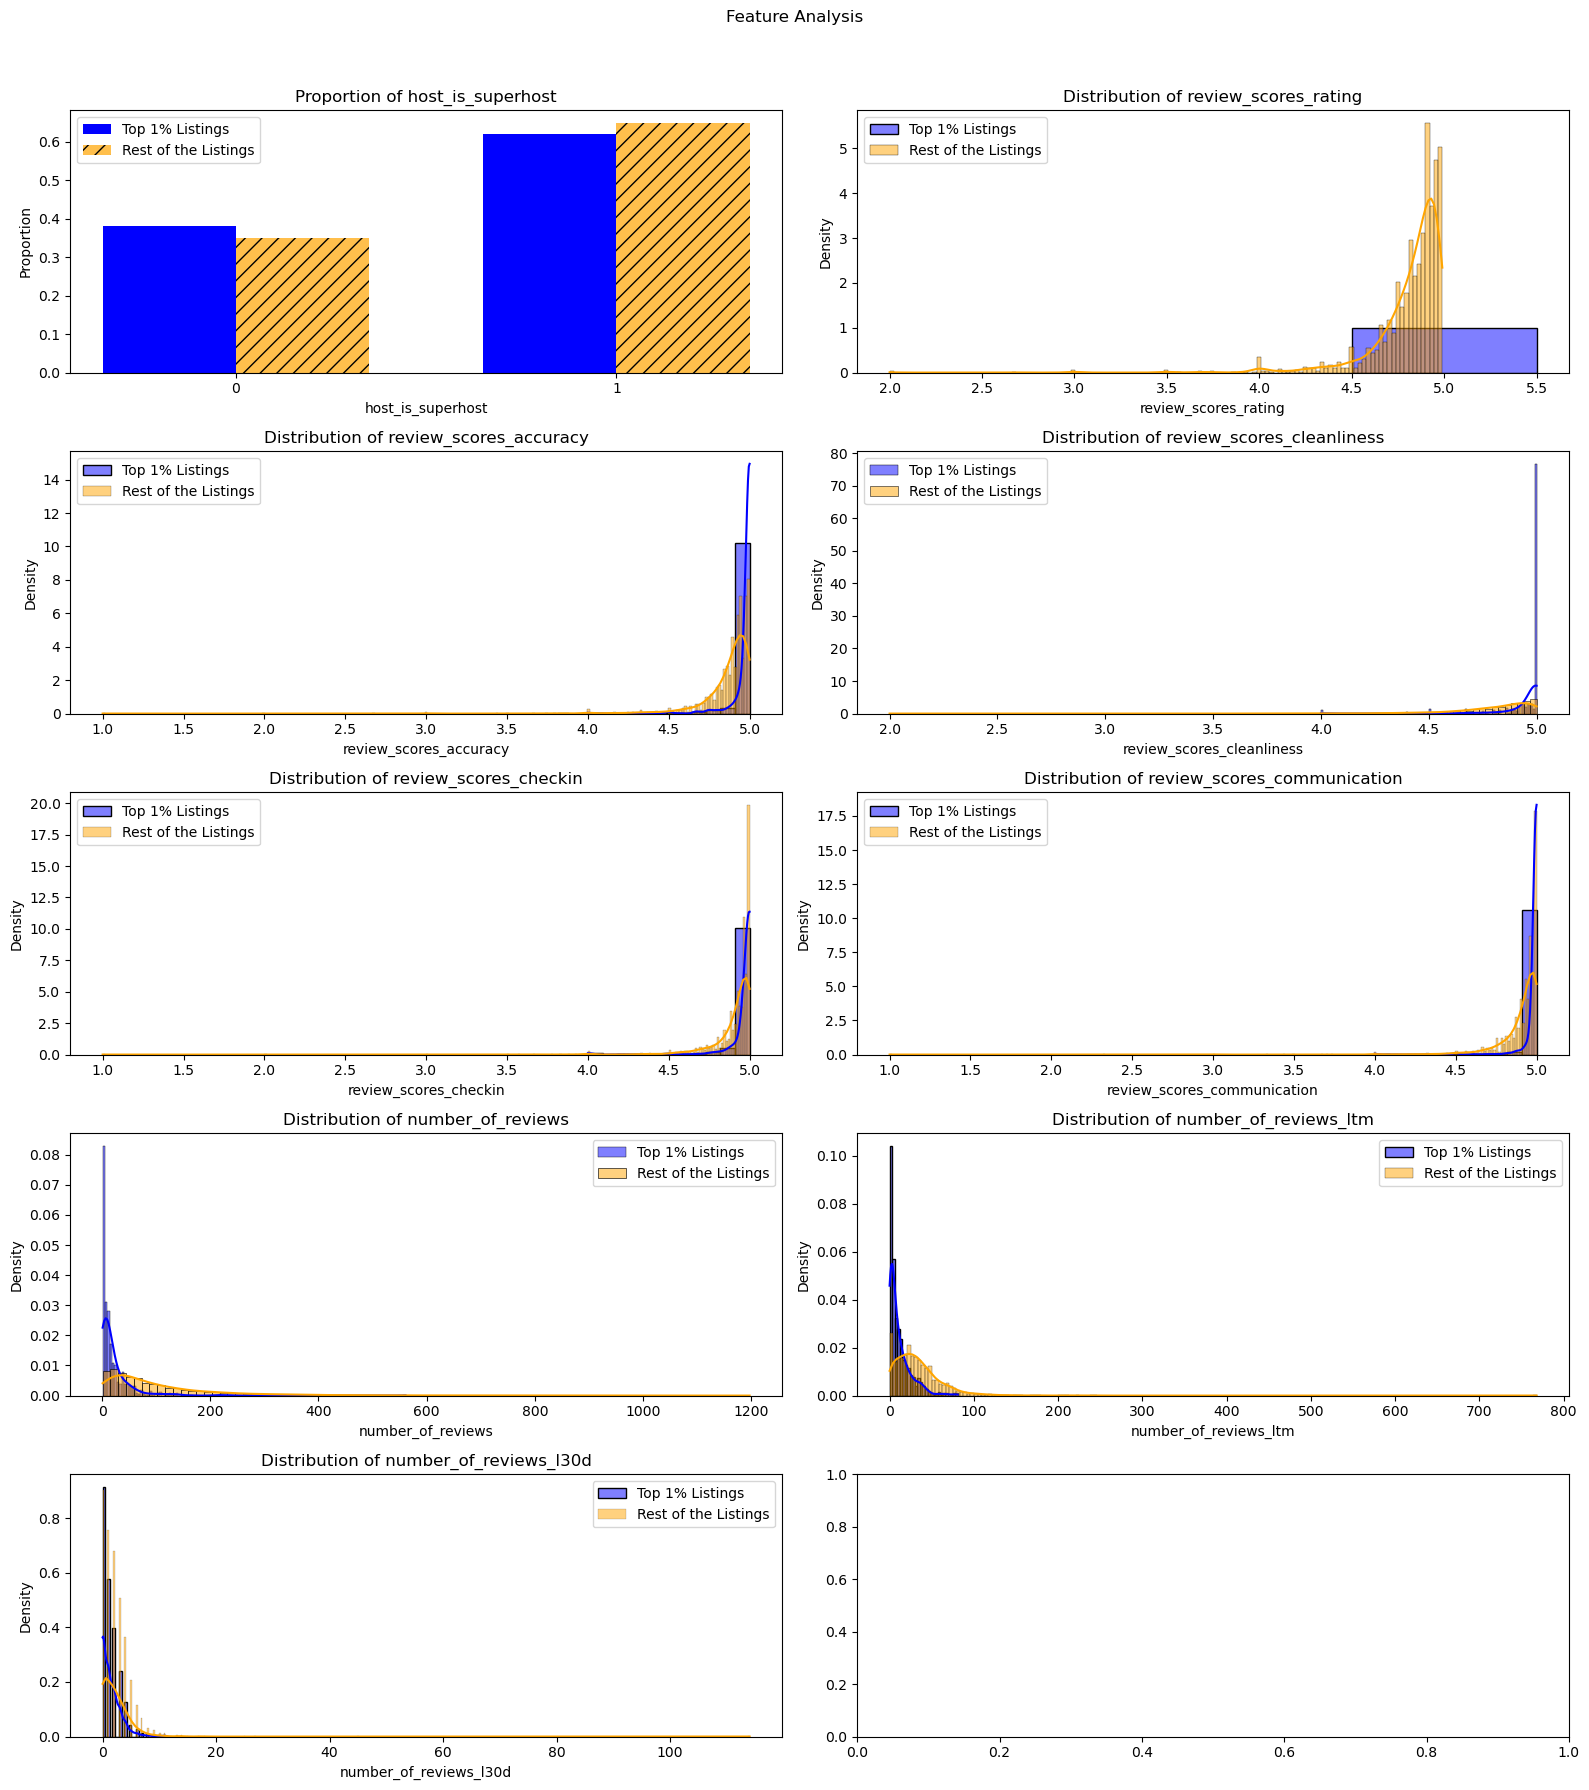

In [88]:
plots_(df_preprocessed,top_1_percent_listings,experience)


#### Insights about Top 1 % Listings (by review_score_rating)
- Top listings do not have a higher proportion of superhosts.
- Top listings have higher proportion of very high review scores across all categories - accuracy, cleanliness,checkin and communication. Very high chance that review_scores_rating (based on which our top listings are identified) was calculated from these individual review scores. If not, they provide good insight into what parameters matter to get a high review_score_rating.
- Top listings do not have higher proportion of high number of reviews

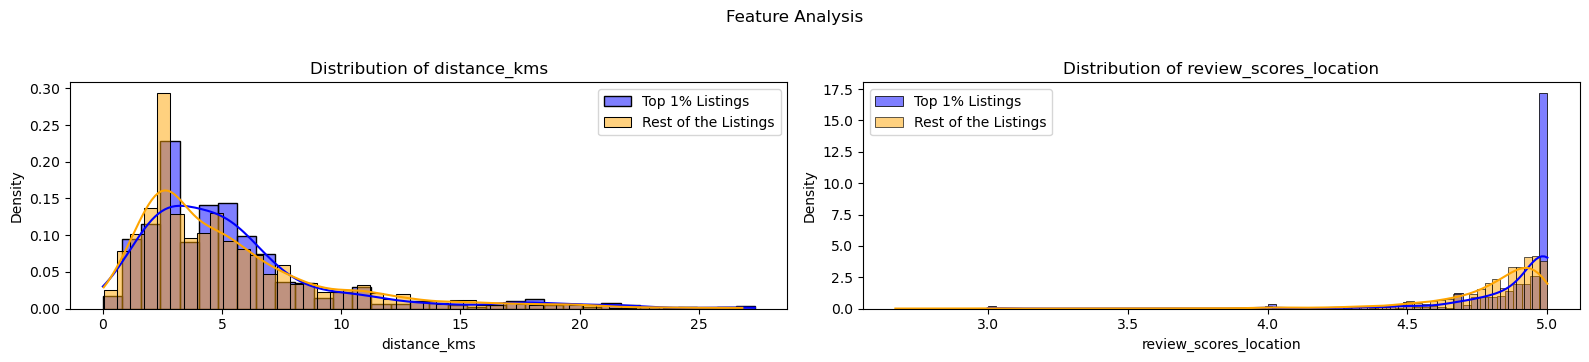

In [89]:
plots_(df_preprocessed,top_1_percent_listings,location)


#### Insights about Top 1 % Listings (by review_score_rating)
- Top listings have a marginally higher proportion of high review scores for location 

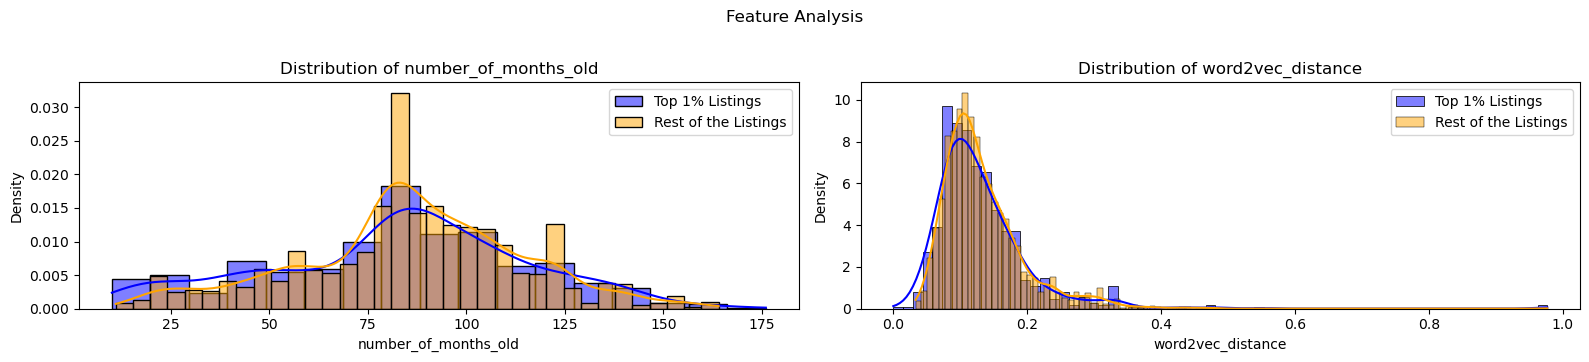

In [90]:
plots_(df_preprocessed,top_1_percent_listings,others)


#### Insights about Top 1 % Listings (by review_score_rating)
- There is not much to differentiate between the 2 groups in terms of age of the property and similarity to Amy's listing description

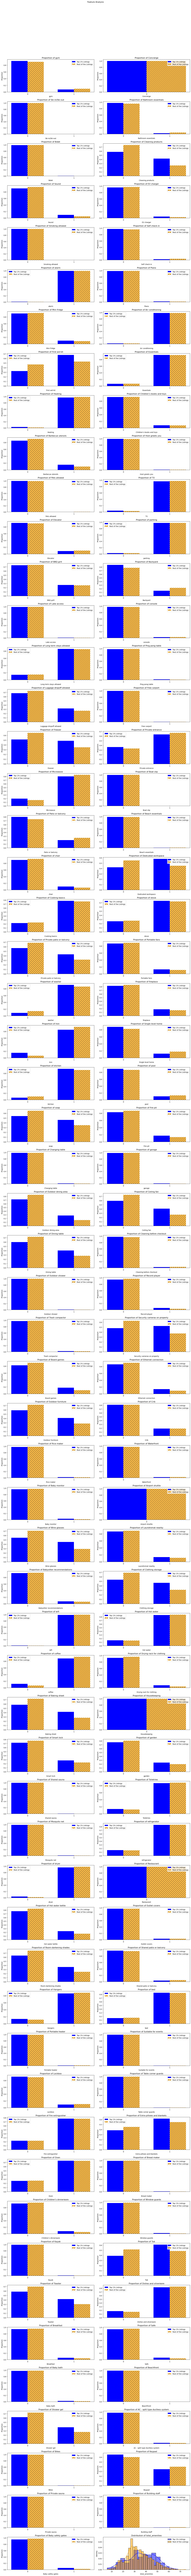

In [91]:
plots_(df_preprocessed,top_1_percent_listings,amenities)


#### Insights about Top 1 % Listings (by review_score_rating)
- Compared to the rest of the listings, top listings have a higher proportion of properties with the following amenities  - 

Board games, shower gel, bathtub, first aid kit, washer, cleaning products, outdoor furniture, security cameras, chairs, children's dinnerware, wine glasses, freezer, luggage dropoff allowed, extra pillows and blankets, toaster, baking sheet, private patio or balcony, dedicated workspace, ceiling fan, room darkening shaded, drying rack for clothing, soap, sound boxes, kettles, garden, outdoor dining area, barbeque utensils, dining table.

- Having these additional amenities seem to provide a better experience for the customers leading to higher scores.
- From the distribution of the Total amenities count, we see that higher proportion of top listings seem to have more than 40 amenities compared to the rest of the listings  

##### Statistical Tests

Based on the analysis, following (alternate) hypothesis needs to be tested for statistical significance

There is significant difference between top listings (highly rated) and the rest with respect to -  
- capacity (count of beds, bathrooms, bedrooms, accommodates) 
- price
- review_scores_value
- Total Amenities count

In [92]:
df = df_preprocessed.copy()
top_listings = top_1_percent_listings.copy()
rest_listings = df.drop(top_listings.index)
top_listings.shape,rest_listings.shape

((755, 142), (3240, 142))

In [93]:
df.columns.tolist()

['host_is_superhost',
 'accommodates',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'price',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'number_of_months_old',
 'distance_kms',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'gym',
 'Concierge',
 'Ski-in/Ski-out',
 'Bathroom essentials',
 'Bidet',
 'Cleaning products',
 'Sound',
 'EV charger',
 'Smoking allowed',
 'Self check-in',
 'alarm',
 'Piano',
 'Mini fridge',
 'Air conditioning',
 'First aid kit',
 'Essentials',
 'Heating',
 'Children’s books and toys',
 'Barbecue utensils',
 'Host greets you',
 'Pets allowed',
 'TV',
 'Elevator',
 'parking',
 'BBQ grill',
 'Backyard',
 'Lake access',
 'console',
 'Long term stays allowed',
 'Ping pong table',
 'Luggage dropoff allowed',
 'Free car

In [94]:
from scipy.stats import mannwhitneyu
columns=['accommodates','beds','bathrooms_text','bedrooms']

for column in columns:
    # Perform Mann-Whitney U test
    _, p_value = mannwhitneyu(top_listings[column], rest_listings[column])
    # Repeat the test for other capacity variables (bathrooms, bedrooms, accommodates)

    # Check the significance level
    alpha = 0.05
    if p_value < alpha:
        print(f"\nReject Null Hypothesis that there is no significant difference in  # {column} between top listings and the rest. P-value = ",round(p_value,10))
    else:
        print(f"\nFail to reject Null hypothesis that there is no significant difference in  # {column} between top listings and the rest. P-value = ",round(p_value,10))



Reject Null Hypothesis that there is no significant difference in  # accommodates between top listings and the rest. P-value =  0.0

Reject Null Hypothesis that there is no significant difference in  # beds between top listings and the rest. P-value =  1e-10

Reject Null Hypothesis that there is no significant difference in  # bathrooms_text between top listings and the rest. P-value =  0.0

Reject Null Hypothesis that there is no significant difference in  # bedrooms between top listings and the rest. P-value =  0.0


In [95]:
from scipy.stats import ttest_ind, mannwhitneyu
column ='price'
# Perform independent t-test if assumptions are met, otherwise Mann-Whitney U test
_, p_value = ttest_ind(top_listings[column], rest_listings[column])
# If assumptions are violated, use Mann-Whitney U test: 
# _, p_value = mannwhitneyu(top_listings[column], rest_listings[column])

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print(f"\nReject Null Hypothesis that there is no significant difference in {column} between top listings and the rest. P-value = ",round(p_value,10))
else:
    print(f"\nFail to reject Null hypothesis that there is no significant difference in {column} between top listings and the rest. P-value = ",round(p_value,10))



Reject Null Hypothesis that there is no significant difference in price between top listings and the rest. P-value =  0.0


In [96]:
from scipy.stats import ttest_ind, mannwhitneyu
column='review_scores_value'
# Perform independent t-test if assumptions are met, otherwise Mann-Whitney U test
_, p_value = ttest_ind(top_listings[column], rest_listings[column])
# If assumptions are violated, use Mann-Whitney U test: 
# _, p_value = mannwhitneyu(top_listings[column], rest_listings[column])

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print(f"\nReject Null Hypothesis that there is no significant difference in {column} between top listings and the rest. P-value = ",round(p_value,10))
else:
    print(f"\nFail to reject Null hypothesis that there is no significant difference in {column} between top listings and the rest. P-value = ",round(p_value,10))



Reject Null Hypothesis that there is no significant difference in review_scores_value between top listings and the rest. P-value =  0.0


In [97]:
from scipy.stats import mannwhitneyu
column='total_amenities'
# Perform Mann-Whitney U test
_, p_value = mannwhitneyu(top_listings[column], rest_listings[column])

# Check the significance level
alpha = 0.05
if p_value < alpha:
    print(f"\nReject Null Hypothesis that there is no significant difference in {column} between top listings and the rest. P-value = ",round(p_value,10))
else:
    print(f"\nFail to reject Null hypothesis that there is no significant difference in {column} between top listings and the rest. P-value = ",round(p_value,10))



Reject Null Hypothesis that there is no significant difference in total_amenities between top listings and the rest. P-value =  0.0


In [98]:
value

['price', 'review_scores_value']

All our hypothesis have been showed to be true by testing for statistical significance.

In [99]:
#Amy's features
amy_features=df_preprocessed.loc[5196][df_preprocessed.loc[5196].values !=0].index.tolist()
amy_amenities=set(amy_features)-set(basic_requirement)-set(value)-set(experience)-set(others)

significant_amenities= ['Board games','Baking sheet', 'Barbecue utensils','Tub','Ceiling fan','chair',
 "Children's dinnerware",'Cleaning products','Dedicated workspace','Dining table','Drying rack for clothing',
 'Extra pillows and blankets','First aid kit','freezer','garden','Hot water kettle','luggage dropoff allowed',
 'outdoor dining area','outdoor furniture','Patio or balcony','room-darkening shades',
 'Security cameras on property','shower gel','soap','sound','toaster','washer','wine glasses']

significant_amenities = [ i.lower() for i in significant_amenities]
amy_amenities = [ i.lower() for i in amy_amenities]
amy_premium_amenities = [i for i in amy_amenities if i in significant_amenities]

print("count of Amy's premium amenities - ",len(amy_premium_amenities))
amy_premium_amenities

count of Amy's premium amenities -  14


['freezer',
 'outdoor furniture',
 'cleaning products',
 'sound',
 'extra pillows and blankets',
 'dedicated workspace',
 'washer',
 'wine glasses',
 'soap',
 'tub',
 'toaster',
 'shower gel',
 'baking sheet',
 'dining table']

#### Features that help Amy's listing be in the top 1%
- Better service provided by Amy leading to Customer delight (before, during and after check-out experience)
- Value for the price paid & Amenities (Total & Premium)
- Has more beds and accommodates more people